In [31]:
import rasterio
import os, time, datetime
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, set_link_color_palette
from dtw import *
from skimage.segmentation import felzenszwalb
from rasterio.features import shapes as rio_shapes
from shapely.geometry import shape
from shapely.geometry.multipolygon import MultiPolygon
import cv2
import math
from scipy.ndimage import uniform_filter
from datetime import datetime
from pygeosys.timeserie.smoothers import  whitw
import joblib
import warnings

warnings.filterwarnings("ignore") #Hide messy numpy warnings
pd.options.display.float_format ='{:.2f}'.format

In [32]:
data_path = 'data/'  # path for image time series, each stocked in a file folder named with the sfd_id
modis= 'MODIS/'
image= 'MultiSpectral/'
sar = 'SAR/'

data_modis = data_path + modis
data_image = data_path + image
data_sar = data_path + sar

In [33]:
dataPath = 'CSV_Data/'
file = 'SoyExRains.csv'
data = pd.read_csv(dataPath+file, sep=';')
data = pd.DataFrame(data)
usecols = ['sfd_id','WKT']
rename = {
            'WKT': 'geometry',
            'sfd_id': 'Sfd_id'
}
data = data[usecols]
data.rename(columns=rename, inplace=True)
# to check the index from interupting process
data

Sfd_id                                           geometry
0  104839603  MULTIPOLYGON (((-50.28868413 -21.21892931,-50....
1  104851010  MULTIPOLYGON (((-51.64726684 -23.30727236,-51....
2  104851011  MULTIPOLYGON (((-51.64079547 -23.29584802,-51....
3  104856056  MULTIPOLYGON (((-51.2694129 -23.23388657,-51.2...
4  104856307  MULTIPOLYGON (((-51.86434054 -22.80493581,-51....
5  104838039  MULTIPOLYGON (((-54.15842318 -25.22023698,-54....
6  104856508  MULTIPOLYGON (((-54.2316334 -20.94611016,-54.2...
7  104852841  MULTIPOLYGON (((-49.32213409 -23.02007774,-49....

In [34]:
sfd_ids = data['Sfd_id'].unique() 
idx = 0 # done-5
# sfd_ids = np.array(sfd_ids[idx:idx+1])
sfd_ids = np.array(sfd_ids[:])
savePath = 'ImageResults/SAR_Rescontruction/'
sfd_ids

array([104839603, 104851010, 104851011, 104856056, 104856307, 104838039,
       104856508, 104852841], dtype=int64)

# Function

In [35]:
#### SAR Processing
def data_extractor(data_path, sfd_id_choice, year_choice):
    """
    Extract and save file names for SAR image tif 
    of a given field after filtering repeated images
        Parameters
    ----------
    data_path : string
        relative path for the images files
    sfd_id_choice : int or string
        season field id
    year_choice : int or string
        year. example : 2020
        
    Returns
    -------
    sar_tif_file : string list
        list with all ndvi image .tif file names
    """
    all_names = os.listdir(data_path + str(sfd_id_choice) + '/'+ str(year_choice) )
    #image_names = [el for el in all_names if el.split('_')[2][:4] == str(year_choice)]
    image_names = sorted(all_names)
        
    sar_tif_file= ['None']
    for img in image_names:        
        sar_tif_file.append(img)        
    sar_tif_file.pop(0)    
    return sar_tif_file

def RasterReading_MaskingNan(file,chanel=1):
    '''
    Reading the rasterio by choosing the chanel    
    ----------
    Parameters:
    file : repository of the file
    chanel : int
        Input chanel (chanel = # 1 -VV/ 2-VH band)       
    -------
    Returns:    
    sar_tif_file : string list
        list with all ndvi image .tif file names
    ----------
    Examples:   
    sar_image = RasterReading_MaskingNan(file,chanel=1)
    '''
    sar_raster_band  = rasterio.open(file)
    sar_image = sar_raster_band.read(chanel)        
    sar_image = np.nan_to_num(sar_image, nan = 0)
    sar_image = np.ma.masked_values(sar_image,0)
    return sar_image

def StandardSize(data_path,fileList,year_choice):
    '''
    Return standard size(max_size) of SAR image
    Std_Size = StandardSize(data_path,fileList,year_choice)
    '''
    ListAP = []
    for idx,img in enumerate(fileList):
        sfd_id = img.split('_')[0]        
        file = data_path + sfd_id +'/' + str(year_choice)+'/'+fileList[idx]        
        sar_image = RasterReading_MaskingNan(file)
        availabel_pixel = sar_image.size - sar_image.mask[sar_image.mask == True].sum()        
        ListAP.append(availabel_pixel)
    return np.max(np.unique(ListAP, return_counts=True))

def EliminateNonStandardSize(data_path, fileList,year_choice):
    '''
    Keep only the standard size of SAR images
    EliminateNonStandardSize(data_path, sar_tif_file)
    '''
    to_delete = []
    Std_Size = StandardSize(data_path,fileList,year_choice)
    for idx,img in enumerate(fileList):
        sfd_id = img.split('_')[0]        
        file = data_path + sfd_id +'/' + str(year_choice)+'/'+fileList[idx]        
        sar_image = RasterReading_MaskingNan(file)
        availabel_pixel = sar_image.size - sar_image.mask[sar_image.mask == True].sum()
        
        if availabel_pixel <= 0.9*Std_Size:            
            to_delete.append(idx)
            
    sar_tif_file = np.delete(fileList,to_delete, axis=0)
    return sar_tif_file

def decibel_to_linear(band):
     # convert to linear units
    return np.power(10,np.array(band)/10)

def linear_to_decibel(band):
    # convert to decibel
    return 10*np.log10(band)

def lee_filter(band, window, var_noise =0.25):
    '''
    SAR despeckling nosie (Additive LEE filter)
    See more method:
    https://desktop.arcgis.com/en/arcmap/10.3/manage-data/raster-and-images/speckle-function.htm#GUID-F45976F8-09C5-4344-B249-FBAA03517B8A
    
    Implement the Lee fileter for a band in an image aldready reshaped into the proper dimensions    
    # band: SAR data to be despeckled (already reshaped into image dimensions)
    # window: descpeckling filter window (tuple)
    # default noise variance = 0.25
    # assumes noise mean = 0
    ## Test ting leefilter with different window and noise-var
    windows = [2,4,8]
    noise_var=np.array([1,2,4])
    noise_var_1 = np.round(np.var(band_1_linear)*noise_var,10)
    for i im range(3):
     for j in range(3):
        Value = lee_filter(VV, windows[i],noise_var_1[j])
    # Validating code
    windows = [2,4,8]
    noise_var = np.round(np.ma.var(SAR_numpy[0])*1,4)
    sar_despeckling = lee_filter(SAR_numpy[0],windows[0],noise_var)
    '''
    # Compute mean and var of window
    mean_window = uniform_filter(band, window)
    mean_sqr_window = uniform_filter(band**2, window)
    var_window = mean_sqr_window - mean_window**2
    # K = Lv/(Lv+Av) - Weight updating
    weights = var_window /(var_window + var_noise)
    # Filtered pixel = LM +K*(Pc-Lm)
    band_filtered = mean_window + weights*(band - mean_window)
    return band_filtered

def Generate_All_SAR_Image(data_path,year_choice,fileList, savePath,close=False,save=False): 
    ''' 
    chanel = # 1 -VV(default)/ 2-VH band
    # Generate the set of SAR images 
    SAR_numpy_des, SAR_numpy, DATE, SAR_mean, SAR_std, SAR_med = Generate_NDVI_Image(data_path,year_choice,sar_tif_file,savePath,close=True,save=False)
    RVI index:= 4*VH/(VV+VH) # VV-1 / VH 2
    '''       
    SAR_numpy = []
    SAR_numpy_des = []
    DATE = []
    SAR_mean = []
    SAR_std = []
    SAR_med = []
    SAR_max = []
    SAR_min = []
    windows = [2,4,8]
    NoImage = len(fileList)
    ncols = 4    
    NoRows = int(math.ceil(NoImage/ncols))
    plt.close('all')
    fig, ax = plt.subplots(nrows= NoRows , ncols=ncols , figsize=(25,10) )    
    for idx,img in enumerate(fileList):                
        sfd_id = img.split('_')[0]
        Date = img.split('_')[2]
        file = data_sar + sfd_id +'/' + str(year_choice)+'/'+ fileList[idx] 
        RVI_image = RasterReading_MaskingNan(file,1)
        # Despeckling Noise        
        noise_var = np.round(np.ma.var(RVI_image)*1,4)        
        sar_despeckling = lee_filter(RVI_image,windows[1],noise_var)
        # Image statistics
        mean = np.ma.mean(sar_despeckling)
        std = np.ma.std(sar_despeckling)
        med = np.ma.median(sar_despeckling)
        max = np.ma.max(sar_despeckling)
        min = np.ma.min(sar_despeckling)
        # Image Information Storage        
        SAR_numpy.append(RVI_image)
        SAR_numpy_des.append(sar_despeckling)
        DATE.append(Date)
        SAR_mean.append(mean)
        SAR_std.append(std)
        SAR_med.append(med)
        SAR_max.append(max)
        SAR_min.append(min)
        
        #cmap, norm = get_palette(ndvi_image)
        row,col = idx//ncols, idx%ncols        
        ax[row][col].set_title(f'{Date}-SAR_mean: {mean:.2f}')
        a = ax[row][col].imshow(
            RVI_image,
            cmap='RdYlGn',# gray - jet
        )        
        ax[row][col].axis('off')
        a.set_clim(vmin=0, vmax=1)
        
    fig.colorbar(a, ax=ax[:,:])
    fig.suptitle(f'Field ID:{sfd_id} from {DATE[0]} to {DATE[-1]}')        
    if save:
        if not os.path.exists(f'{savePath}/SAR_Images'):
            os.makedirs( f'{savePath}/SAR_Images/')
        plt.savefig(f'{savePath}/SAR_Images/{sfd_id}.png ',format='png')        
    plt.show()
    if close:
        plt.close('all')    
    return SAR_numpy_des, SAR_numpy, DATE, SAR_mean, SAR_std, SAR_med, SAR_max, SAR_min

#### Multispectral Processing

def Multispectral_data_extractor(data_path, sfd_id_choice, year_choice):
    '''
    band_tif_file, ndvi_tif_file = Multispectral_data_extractor(data_image, sfd_id_choice, year_choice)
    '''
    all_names = os.listdir(data_path + str(sfd_id_choice) + '/'+ str(year_choice) )
    #image_names = [el for el in all_names if el.split('_')[2][:4] == str(year_choice)]
    image_names = sorted(all_names)
    
    band_tif_file= ['None']
    ndvi_tif_file= ['None']
    
    for img in image_names:
        if img.split('_')[1] == 'Ndvi':
            ndvi_tif_file.append(img)
        else:
            band_tif_file.append(img)
    
    band_tif_file.pop(0)
    ndvi_tif_file.pop(0)    
    
    return band_tif_file, ndvi_tif_file
def CorrespondingProcessing(ndvi_tif_file, band_tif_file):     
    '''
    # Eliminate the band images without having the corresponding ndvi images  
    band_tif_file = CorrespondingProcessing(ndvi_tif_file,band_tif_file)
    '''
    keep = []
    for i in range(len(ndvi_tif_file)):
        for j in range(len(band_tif_file)):
            if ndvi_tif_file[i].split('_')[2] == band_tif_file[j].split('_')[2]:
                keep.append(band_tif_file[j])
    return np.array(keep)

def Generate_NDVI_Image(data_path,year_choice,fileList, savePath,close=False,save=False): 
    ''' Generate the set of NDVI images '''       
    NDVI_numpy = []
    DATE = []
    NDVI_mean = []
    NDVI_std = []
    NDVI_med = []
    NoImage = len(fileList)
    ncols = 4    
    NoRows = int(math.ceil(NoImage/ncols))
    plt.close('all')
    fig, ax = plt.subplots(nrows= NoRows , ncols=ncols , figsize=(25,10) )    
    for idx,img in enumerate(fileList):
        sfd_id = img.split('_')[0]
        Date = img.split('_')[2]
        file = data_path + sfd_id +'/' + str(year_choice)+'/'+ fileList[idx] 
        ndvi_image = RasterReading_MaskingNan(file,1)                  
        # Image statistic
        mean = np.ma.mean(ndvi_image)
        std = np.ma.std(ndvi_image)
        med = np.ma.median(ndvi_image)
        # Image Information Storage
        NDVI_numpy.append(ndvi_image)
        DATE.append(Date)
        NDVI_mean.append(mean)
        NDVI_std.append(std)
        NDVI_med.append(med)
        
        #cmap, norm = get_palette(ndvi_image)
        row,col = idx//ncols, idx%ncols        
        ax[row][col].set_title(f'{Date}-NDVI_mean: {mean:.2f}')
        a = ax[row][col].imshow(
            ndvi_image,
            cmap='RdYlGn',
        )        
        ax[row][col].axis('off')
        #plt.colorbar(a)
        # Set the colorbar scale
        a.set_clim(vmin=0, vmax=1)
        
    fig.colorbar(a, ax=ax[:,:])
    fig.suptitle(f'Field ID:{sfd_id} from {DATE[0]} to {DATE[-1]}')        
    if save:
        if not os.path.exists(f'{savePath}/NDVI'):
            os.makedirs( f'{savePath}/NDVI/')
        plt.savefig(f'{savePath}/NDVI/{sfd_id}.png ',format='png')        
    
    plt.show()
    if close:
        plt.close('all')  
    return NDVI_numpy, DATE, NDVI_mean, NDVI_std, NDVI_med

### MODIS processing
def Generate_MODIS_Image(data_path,year_choice,fileList, savePath,close=False,save=False): 
    ''' Generate the set of MODIS images '''       
    MODIS_numpy = []
    DATE = [] 
    modis_mean = []
    modis_std = []
    modis_med = []
    modis_max = []
    modis_min = []
    NoImage = len(fileList)
    ncols = 4    
    NoRows = int(math.ceil(NoImage/ncols))
    plt.close('all')
    fig, ax = plt.subplots(nrows= NoRows , ncols=ncols , figsize=(25,50) )    
    for idx,img in enumerate(fileList):
        sfd_id = img.split('_')[0]
        Date = img.split('_')[2]
        file = data_path + sfd_id +'/' + str(year_choice)+'/'+ fileList[idx]        
        modis_numpy = RasterReading_MaskingNan(file,1)
        
        # Image statistic
        mean = np.ma.mean(modis_numpy)
        std = np.ma.std(modis_numpy)
        med = np.ma.median(modis_numpy)
        max = np.ma.max(modis_numpy)
        min = np.ma.min(modis_numpy)
        # Image Information Storage
        MODIS_numpy.append(modis_numpy)
        DATE.append(Date)
        modis_mean.append(mean)
        modis_std.append(std)
        modis_med.append(med)
        modis_max.append(max)
        modis_min.append(min)
        
        #cmap, norm = get_palette(ndvi_image)
        row,col = idx//ncols, idx%ncols        
        ax[row][col].set_title(f'{Date}- NDVI_mean:{mean:.4f}')
        a = ax[row][col].imshow(
            modis_numpy,
            cmap='RdYlGn',
        )        
        ax[row][col].axis('off')
        #plt.colorbar(a)
        # Set the colorbar scale
        a.set_clim(vmin=0, vmax=1)
        
    fig.colorbar(a, ax=ax[:,:])
    fig.suptitle(f'Field ID:{sfd_id} from {DATE[0]} to {DATE[-1]}')        
    if save:
        if not os.path.exists(f'{savePath}/MODIS'):
            os.makedirs( f'{savePath}/MODIS/')
        plt.savefig(f'{savePath}/MODIS/{sfd_id}.png ',format='png')        
    plt.show()
    if close:
        plt.close('all')  
    return MODIS_numpy, DATE, modis_mean, modis_std, modis_med, modis_max, modis_min

### Data Combination 
def DecrivedData(df_input,list_date,column='Date'):
    # SAR_Der_df = DecrivedData(SAR_df,sar_list_date).reset_index(drop=False)
    df = pd.DataFrame()
    for List in list_date:
        cond = df_input[column] == List
        df = pd.concat([df, df_input[cond]])
    return df

def DataFrameAggregation(sfd_id_choice,year_choice,SAR_df,sar_list_date,NDVI_df,NDVI_list_date,modis_df,save=False):
    '''
    df_list_date = pd.read_csv(f'{sfd_id}.csv', sep=';')
    sar_list_date = df_list_date.loc[year_choice,'SAR_Date']
    NDVI_list_date =df_list_date.loc[year_choice,'NDVI_Date']    
    Return the DataFrame Combination between SAR and NDVI
    # df_image_dataset = DataFrameAggregation(sfd_id_choice,year_choice,SAR_df,sar_list_date,NDVI_df,NDVI_list_date,modis_df,save=False)
    '''
    SAR_Der_df = DecrivedData(SAR_df,sar_list_date).reset_index(drop=False)
    NDVI_Der_df = DecrivedData(NDVI_df,NDVI_list_date).reset_index(drop=False)
    df_image = SAR_Der_df.join(NDVI_Der_df,rsuffix='_NDVI')
    df_image = df_image.merge(modis_df, on='Date')
    columns = ['Date','SAR_mean','SAR_std','SAR_med','SAR_max','SAR_min','modis_mean','modis_std','modis_med','modis_max','modis_min','NDVI_mean']
    df_image_dataset = df_image[columns]
    if save:
        if not os.path.exists(f'{savePath}/DataVariables/{sfd_id_choice}'):
            os.makedirs( f'{savePath}/DataVariables/{sfd_id_choice}')        
        df_image_dataset.to_pickle(f'{savePath}/DataVariables/{sfd_id_choice}/df_dataset_{sfd_id_choice}_{year_choice}.pkl')
    return df_image_dataset

def LoadDate_DataAggregation(sfd_id_choice,year_choice,SAR_df,NDVI_df,modis_df,save=False):
    '''
    df_list_date = pd.read_csv(f'{sfd_id_choice}.csv', sep=';')
    df_list_date['SAR_Date'] = df_list_date['SAR_Date'].astype('str')
    df_list_date['NDVI_Date'] = df_list_date['NDVI_Date'].astype('str')
    df_list_date.set_index('Year',inplace=True)
    sar_list_date = df_list_date.loc[year_choice,'SAR_Date'].tolist()
    NDVI_list_date =df_list_date.loc[year_choice,'NDVI_Date'].tolist()
    df_image_dataset = DataFrameAggregation(sfd_id_choice,year_choice,SAR_df,sar_list_date,NDVI_df,NDVI_list_date,modis_df,save=True)
    # df_image_dataset = LoadDate_DataAggregation(sfd_id_choice,year_choice,SAR_df,sar_list_date,NDVI_df,NDVI_list_date,modis_df,save=True)
    '''
    # ReadSAR and NDVI date
    df_list_date = pd.read_csv(f'{savePath}/Date_CSV/{sfd_id_choice}.csv', sep=';')
    df_list_date['SAR_Date'] = df_list_date['SAR_Date'].astype('str')
    df_list_date['NDVI_Date'] = df_list_date['NDVI_Date'].astype('str')
    df_list_date.set_index('Year',inplace=True)
    sar_list_date = df_list_date.loc[year_choice,'SAR_Date'].tolist()
    NDVI_list_date =df_list_date.loc[year_choice,'NDVI_Date'].tolist()
    # Aggregation 
    df_image_dataset = DataFrameAggregation(sfd_id_choice,year_choice,SAR_df,sar_list_date,NDVI_df,NDVI_list_date,modis_df,save=True)
    return df_image_dataset

def DataFrameYearCombination(sfd_id_choice,save=False):
    '''
    df_dataset_2019 = pd.read_pickle("df_dataset_2019.pkl")
    df_dataset_2020 = pd.read_pickle("df_dataset_2020.pkl")
    df_dataset_2021 = pd.read_pickle("df_dataset_2021.pkl")
    df_dataset = pd.concat([df_dataset_2019,df_dataset_2020,df_dataset_2021]).reset_index(drop=True)
    #df_dataset.to_pickle("df_dataset_104838039.pkl")
    df_dataset = DataFrameYearCombination(sfd_id_choice,save=True)
    '''
    df_dataset_2019 = pd.read_pickle(f'{savePath}/DataVariables/{sfd_id_choice}/df_dataset_{sfd_id_choice}_2019.pkl')
    df_dataset_2020 = pd.read_pickle(f'{savePath}/DataVariables/{sfd_id_choice}/df_dataset_{sfd_id_choice}_2020.pkl')
    df_dataset_2021 = pd.read_pickle(f'{savePath}/DataVariables/{sfd_id_choice}/df_dataset_{sfd_id_choice}_2021.pkl')
    df_dataset = pd.concat([df_dataset_2019,df_dataset_2020,df_dataset_2021]).reset_index(drop=True)
    if save:
        if not os.path.exists(f'{savePath}/DataVariables'):
            os.makedirs( f'{savePath}/DataVariables/')        
        df_dataset.to_pickle(f'{savePath}/DataVariables/df_dataset_{sfd_id_choice}.pkl')
    return df_dataset

def Load_Dataset(sfd_ids,save=False):
    '''    
    Aggregrate all the data into a dataset
    ----------
    Attributes:
    sfd_ids : np.array
        List of field id
    ----------
    Returns:    
    df_dataset : pd.DataFrame   
    ----------
    Example:    
    df_dataset = Load_Dataset(sfd_ids)
    '''   
    df_dataset = pd.DataFrame()
    index = 0
    title = f'{len(sfd_ids)}_fields_dataset'
    for sfd_id_choice in sfd_ids:
        df_load = pd.read_pickle(f'{savePath}/DataVariables/df_dataset_{sfd_id_choice}.pkl')
        df_load.insert(0, "id", [index for idx in range(len(df_load))], True)
        df_load.insert(0, "field_id", [sfd_id_choice for idx in range(len(df_load))], True)
        df_dataset = pd.concat([df_dataset,df_load]).reset_index(drop=True)
        index+=1
    
    df_dataset['Date'] = pd.to_datetime(df_dataset['Date'],format='%Y%m%d')
    df_dataset['Date'] = df_dataset['Date'].dt.strftime('%d%m%y')
    if save:
        if not os.path.exists(f'{savePath}/'):
            os.makedirs( f'{savePath}/')        
        df_dataset.to_csv(f'{savePath}/{title}.csv')
        df_dataset.to_pickle(f'{savePath}/{title}.pkl')
    return df_dataset

### Analys Visualization 
def StatisclVisualization(df_dataset,sfd_id_choice,names,save=False):
    '''    
    Aggregrate all the data into a dataset
    ----------
    Attributes:
    df_dataset: pd.DataFrame
        dataset
    sfd_ids : np.array
        List of field id
    names: list
        list of features
    ----------
    Returns:    
    df_dataset : pd.DataFrame   
    ----------
    Example:  
    names = ['SAR_mean','SAR_std','SAR_med']
    StatisclVisualization(df_dataset,sfd_id_choice,names)
    '''
    # df_dataset['Date'] = pd.to_datetime(df_dataset['Date'],format='%Y%m%d')
    # df_dataset['Day'] = df_dataset['Date'].dt.strftime('%d-%m')
    y = df_dataset[names[0]]
    e = df_dataset[names[1]]
    scat = df_dataset[names[2]]
    x = df_dataset['Date']   
    # x = np.linspace(0,len(df_dataset),len(df_dataset))  
    plt.figure(figsize =(20,5))
    plt.errorbar(x, y, e, linestyle='None', marker='.')
    plt.plot(x,y,label='Mean')
    plt.scatter(x,scat,marker='*',label='Med')
    plt.grid()
    #plt.ylim(0,1.2)
    _ = plt.legend()
    title = f'{sfd_id_choice}_{names[0][:3]}'
    plt.title(title)
    plt.xlabel('Date')
    if names[0][:3] == 'SAR':
        yla= 'RVI'
    else:
        yla='NDVI'
    plt.ylabel(yla)
    _ = plt.xticks(rotation=60)
    if save:
        if not os.path.exists(f'{savePath}/'):
            os.makedirs( f'{savePath}/')        
        plt.savefig(f'{savePath}/{sfd_id_choice}_{title}.png')
        
def StatiscalLine(df_dataset,sfd_id_choice,names,save=False):
    '''    
    Plot the statiscal characteristics
    ----------
    Attributes:
    df_dataset : pd.DataFrame
        Dataset dataframe
    names: list
        List of features of the df_dataset
    sfd_id_choice: 
        Chosed field
    save: bool, default=False
        Save the figure
    ----------
    Returns:    
    df_dataset : pd.DataFrame 
        Smoothed DataFrame
    ----------
    Example:
    names = ['SAR_mean','SAR_std','SAR_med']
    names = ['modis_mean','modis_std','modis_med']
    StatiscalLine(df_dataset,sfd_id_choice,names,save=False)
    '''
    NoRows = 3
    fig, ax = plt.subplots(nrows = NoRows , ncols=1 , figsize=(25,12) )
    SAR_mean = df_dataset[names[0]]
    SAR_std = df_dataset[names[1]]
    SAR_med = df_dataset[names[2]]
    Date = df_dataset['Date']    
    for idx,data,name in zip(range(NoRows),[SAR_mean,SAR_std,SAR_med,names],names):
        ax[idx].plot(Date,data)
        ax[idx].set_title(name)
        ax[idx].grid()
        _ = ax[idx].set_xticks(Date.values,Date.values,rotation=10)
    title = 'Statiscal_Lines'    
    if save:
        if not os.path.exists(f'{savePath}/'):
            os.makedirs( f'{savePath}/')        
        plt.savefig(f'{savePath}/{sfd_id_choice}_{title}.png')

def NDVI_plot(df_dataset,sfd_id_choice,save=False):
    '''    
    Plot the label of dataset (NDVI_mean)
    ----------
    Attributes:
    df_dataset : pd.DataFrame
        Dataset dataframe    
    sfd_id_choice: 
        Chosed field
    save: bool, default=False
        Save the figure
    ----------
    Example:
    NDVI_plot(df_dataset,sfd_id_choice)
    '''    
    plt.figure(figsize =(15,5))
    title = f'{sfd_id_choice}_NDVI'
    plt.title(title)
    Date = df_dataset['Date']    
    NDVI = df_dataset['NDVI_mean']
    plt.plot(Date,NDVI)
    plt.grid()
    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.ylabel('NDVI')
    if save:
        if not os.path.exists(f'{savePath}/'):
            os.makedirs( f'{savePath}/')        
        plt.savefig(f'{savePath}/{sfd_id_choice}_{title}.png')

### Data processing
def DataFiltering(df_dataset):
    """
    Filter the dataset with specified condition
    ----------
    Attributes:
    df_dataset : pd.DataFrame 
    ----------
    Returns:    
    df_dataset : pd.DataFrame 
        filtered DataFrame
    ----------
    Example:
    df_filtered_dataset = DataFiltering(df_dataset)
    """
    to_delete = []
    for idx,row in df_dataset.iterrows():
        if row['modis_mean'] < 0 or float(row['modis_std']) < 0.009 :
            to_delete.append(idx)
    df_dataset = df_dataset.drop(to_delete)
    df_dataset = df_dataset.reset_index(drop=True)
    return df_dataset

from sklearn.preprocessing import MinMaxScaler
def FeatureScaling(df_dataset,features,save=False):
    """
    Scale the feature with specified condition
    ----------
    Attributes:
    df_dataset : pd.DataFrame 
    ----------
    Returns:    
    df_dataset : pd.DataFrame 
        scaled DataFrame
    ----------
    Example:
    features = ['SAR_mean','SAR_std','SAR_med','modis_mean','modis_std','modis_med']
    df_scaled_dataset = FeatureScaling(df_dataset,features)
    # Inverse scale
    predictions = scaler.inverse_transform(predictions)
    joblib.dump(my_scaler, 'scaler.gz')
    """     
    df = df_dataset.copy()
    for feature in features:
        scaler = MinMaxScaler()
        data = df[feature].values.reshape(-1,1)        
        scaler = scaler.fit(data)
        scaled_data = scaler.transform(data)
        df[feature] = scaled_data        
        if save:
            if not os.path.exists(f'{savePath}/'):
                os.makedirs( f'{savePath}/')   
            title = f'{savePath}/{feature}_scaler.gz'
            joblib.dump(scaler, title)              
    
    return df    

def Exponential_weighted_average(data,beta=0.65):
    '''    
    Smooth the curve
    Smooth method: weighted_average
    ----------
    Attributes:
    data : np.array
    ----------
    Returns:    
    res : list
        smoothed list
    ----------
    Example:
    smoothedData = Exponential_weighted_average(data,beta=0.55)    
    '''    
    smoothedData =[data[0]]    
    for idx in range(len(data)):        
        smoothedData.append(beta*smoothedData[-1]+(1-beta)*data[idx])    
    return smoothedData[1:]

def whittaker(x, beta=10000):
    '''    
    Smooth the curve
    Smooth method: whittaker
    ----------
    Attributes:
    data : np.array
    ----------
    Returns:    
    res : array
        smoothed array
    ----------
    Example:
    from pygeosys.timeserie.smoothers import  whitw
    data = apply_smoother(df_dataset[feature].values,beta)
    '''        
    weights = (x[0])
    return whitw(x, weights, alpha=3, beta=beta)

def DataSmoothing(df,features,beta=10000):
    '''    
    Smooth the the data
    Smooth method: weighted_average
    ----------
    Attributes:
    df_dataset : pd.DataFrame
    features: list of features of the df_dataset
    ----------
    Returns:    
    df_dataset : pd.DataFrame 
        smoothed DataFrame
    ----------
    Example:
    features = ['SAR_mean','SAR_std','SAR_med','modis_mean','modis_std','modis_med']
    df_smoothed_dataset = DataSmoothing(df_dataset,features,beta=0.65)
    # Smoothing for visualizing purpose only
    # df_smoothed_scaled_filterd_dataset = DataSmoothing(df_scaled_filterd_dataset,features,beta=0.65)
    '''    
    df_dataset = df.copy()
    for feature in features:
        data = whittaker(df_dataset[feature].values,beta)
        df_dataset[feature] = data
    return df_dataset  
### Relevant Feature Augmenter for classification problem
# 2 field
# df_dataset_0 = pd.read_pickle(f'{savePath}/DataVariables/df_dataset_104838039.pkl')
# df_dataset_0.insert(0, "id", [sfd_id_choice for idx in range(len(df_dataset_0))], True)
# df_dataset_0['Class'] = 0

# df_dataset_1 = pd.read_pickle(f'{savePath}/DataVariables/df_dataset_104839603.pkl')
# df_dataset_1.insert(0, "id", [104839603 for idx in range(len(df_dataset_1))], True)
# df_dataset_1['Class'] = 1
# df_dataset = pd.concat([df_dataset_0,df_dataset_1]).reset_index(drop=True)
# df_filtered_dataset = DataFiltering(df_dataset)
# df_scaled_filterd_dataset = FeatureScaling(df_filtered_dataset,features)

# timeseries_train = df_scaled_filterd_dataset.iloc[:,:-2]
# y_train=df_scaled_filterd_dataset[['id','Class']]
# y_train.drop_duplicates(inplace=True)
# y_train = y_train.set_index('id')
# y_train = y_train['Class']

# Single RelevantFeatureAugmenter
# augmenter = RelevantFeatureAugmenter(column_id='id', column_sort='Date')
# augmenter.set_timeseries_container(timeseries_train)
# X_train = pd.DataFrame(index=y_train.index)
# y_pred = augmenter.fit_transform(X_train, y_train)
# Prediction
# augmenter.set_timeseries_container(timeseries_test)
# y_pred = augmenter.transform(X_test)

# pipeline = Pipeline([
#             ('augmenter', RelevantFeatureAugmenter(column_id='id', column_sort='Date')),
#             ('regressor', RandomForestRegressor(n_estimators=15, max_depth=6,random_state=0)),
#             # ('classifier', RandomForestClassifier()),
#             ])
# X_train = pd.DataFrame(index=y_train.index)
# pipeline.set_params(augmenter__timeseries_container = timeseries_train)
# pipeline.fit(X_train, y_train)

# # Prediction
# pipeline.set_params(augmenter__timeseries_container = timeseries_test)
# x_test = pd.DataFrame(index=y_test.index)  
# y_pred = pipeline.predict(X_test) 

In [36]:
## Checking function
def show_image(data, cmap=None):
    '''    
    Show SAR image
    ----------
    Attributes:
    data : np.array 
    ----------
    Returns:    
    show SAR image
    ----------
    Example:
    show_image(SAR_numpy[0],cmap='jet')
    show_image(modis_df.iloc[0,1],cmap='RdYlGn')       
    '''
    plt.close('all')    
    plt.imshow(data, cmap=cmap)
    plt.colorbar()
    plt.show()

def DisplayingAllPixels(data):
    '''    
    Show all SAR image in DataFrame
    ----------
    Attributes:
    data : np.array 
    ----------
    Returns:    
    DataFrame
    ----------
    Example:
    DisplayingAllPixels(SAR_numpy[0])  
    '''
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)    
    return pd.DataFrame(data)  

# Main Code

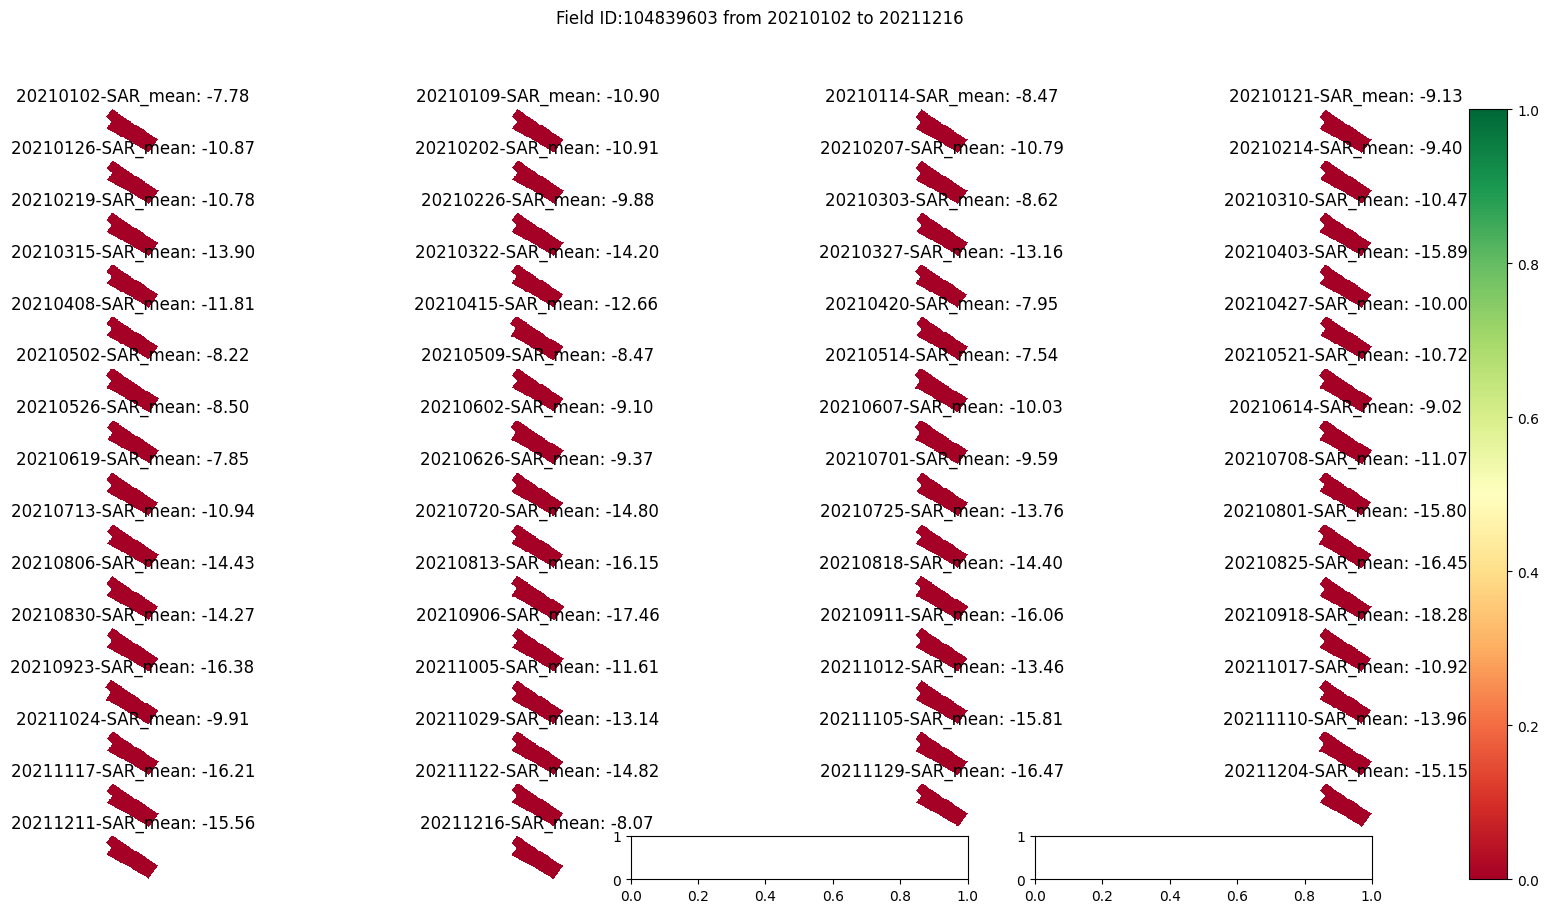

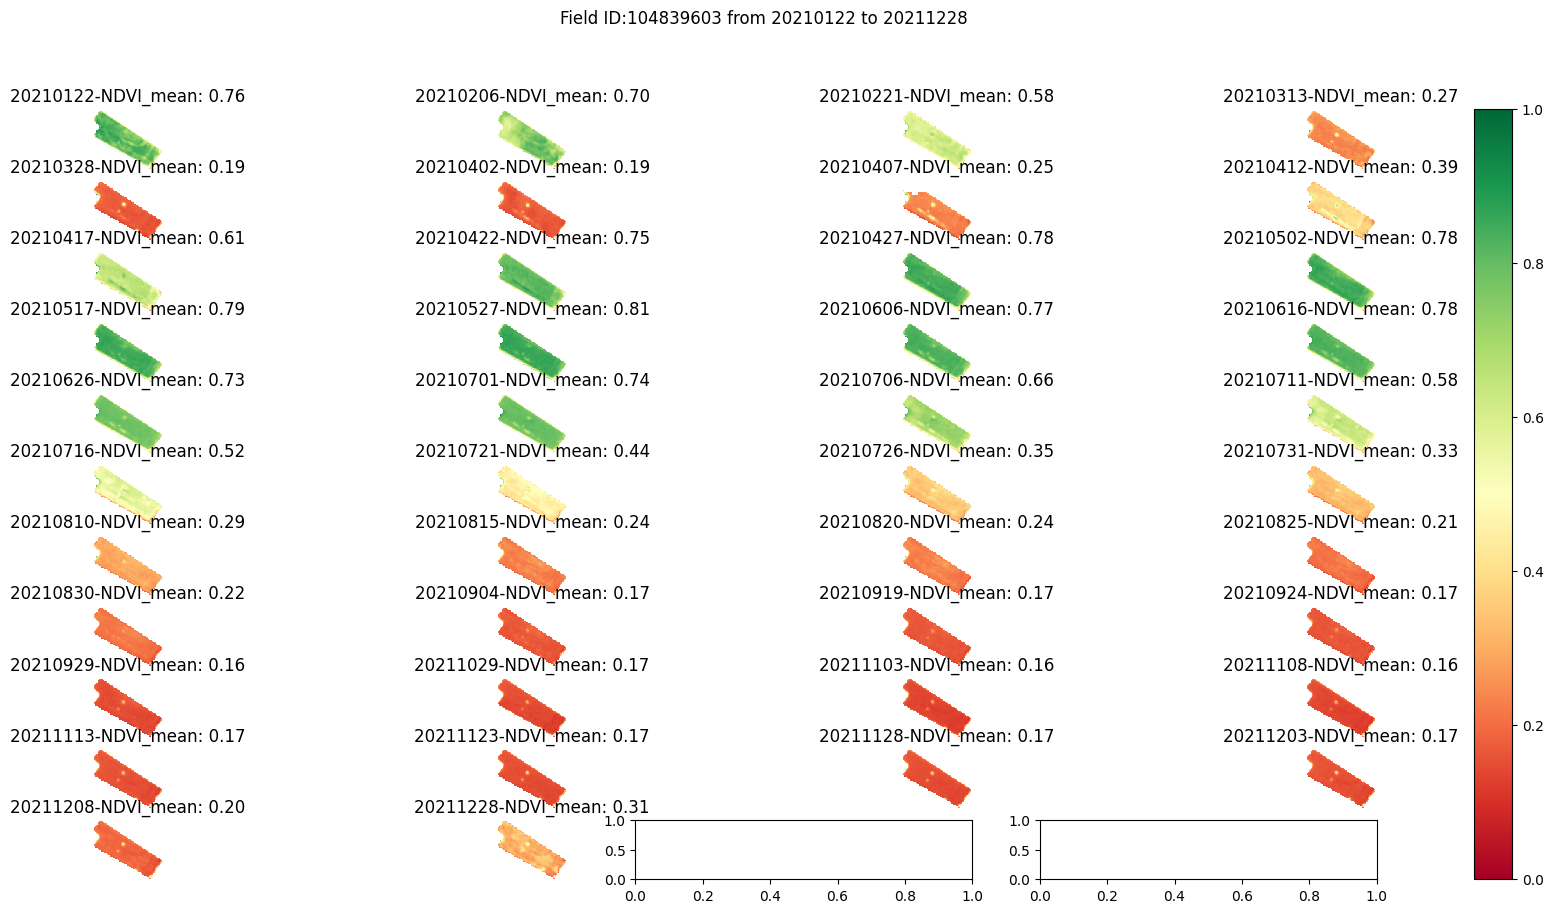

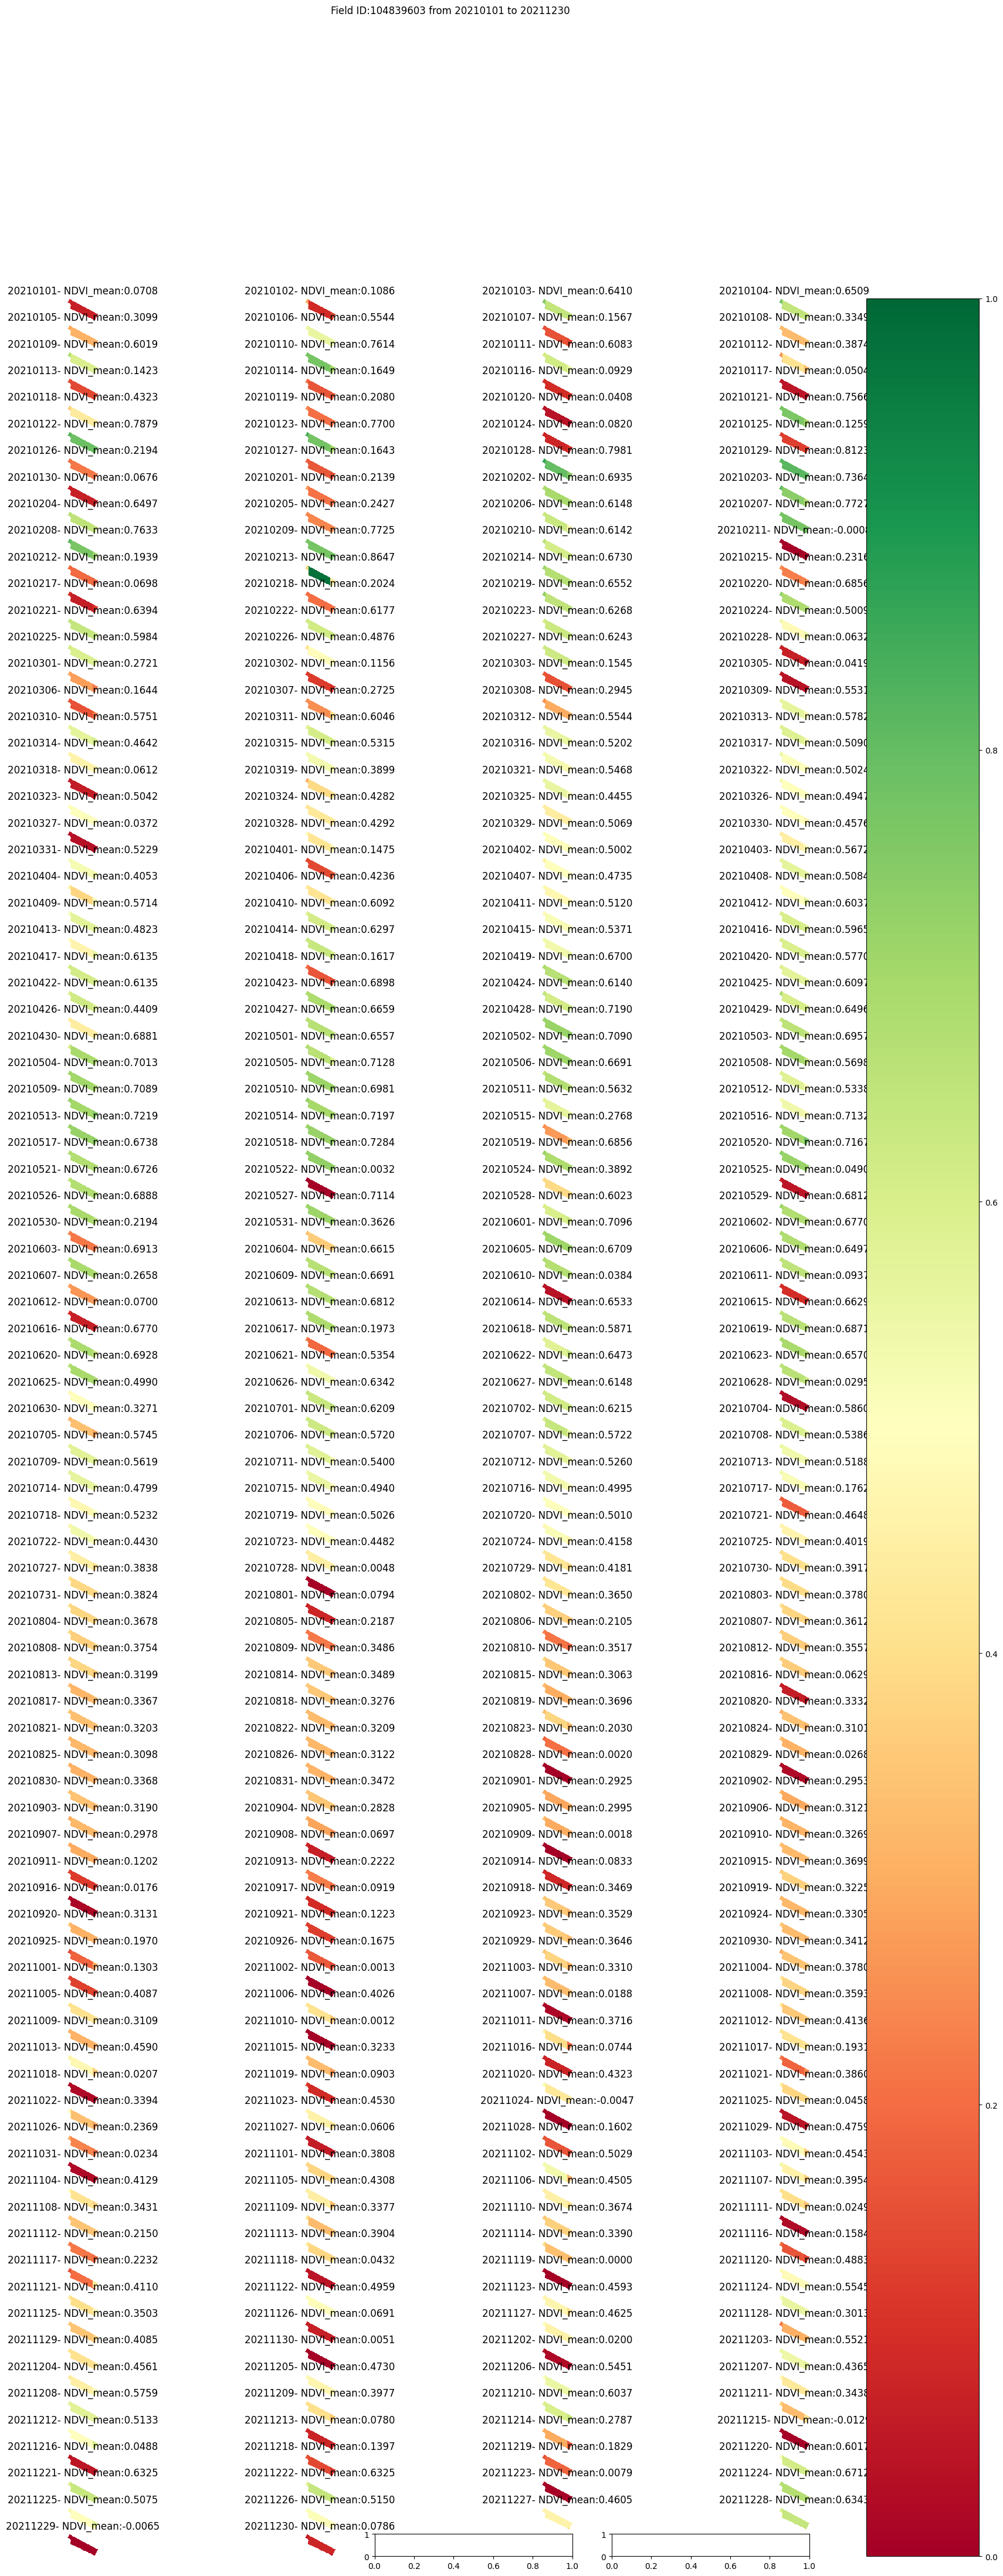

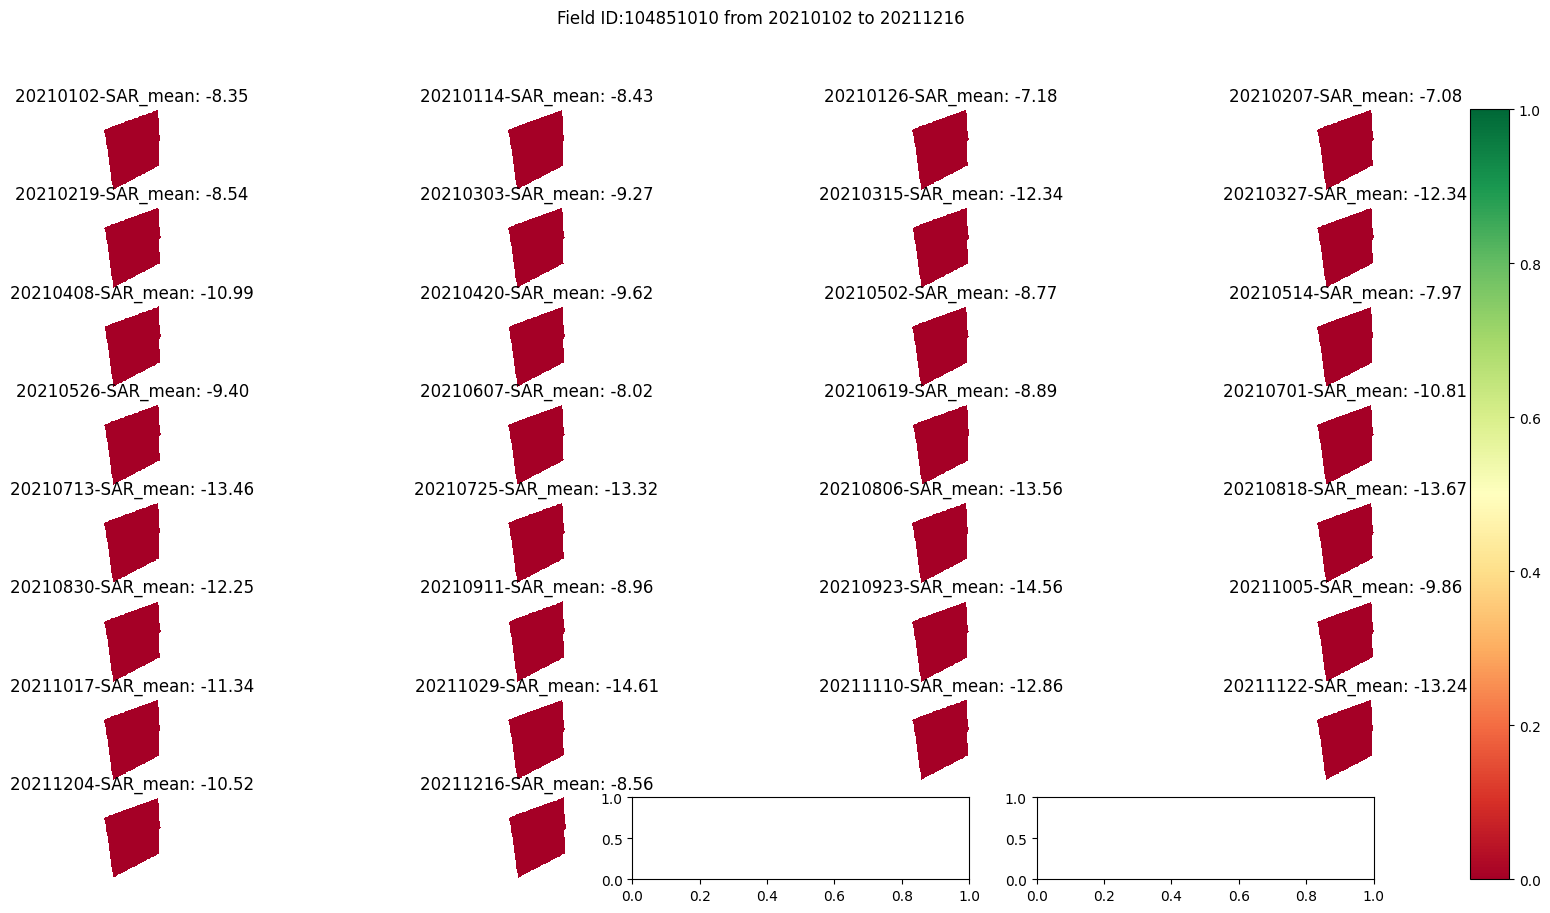

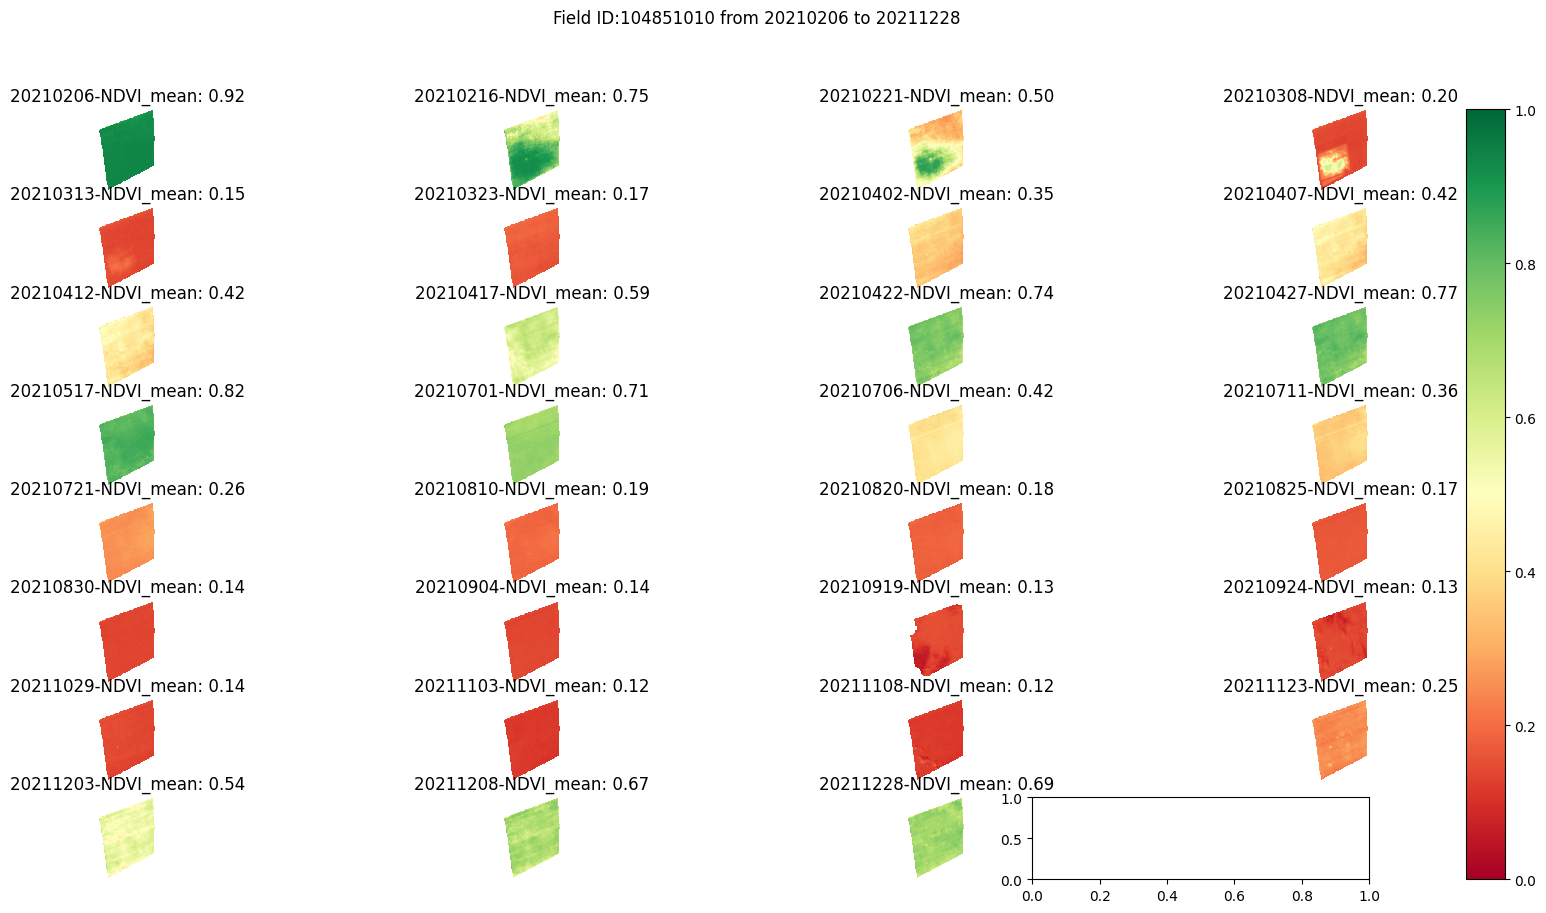

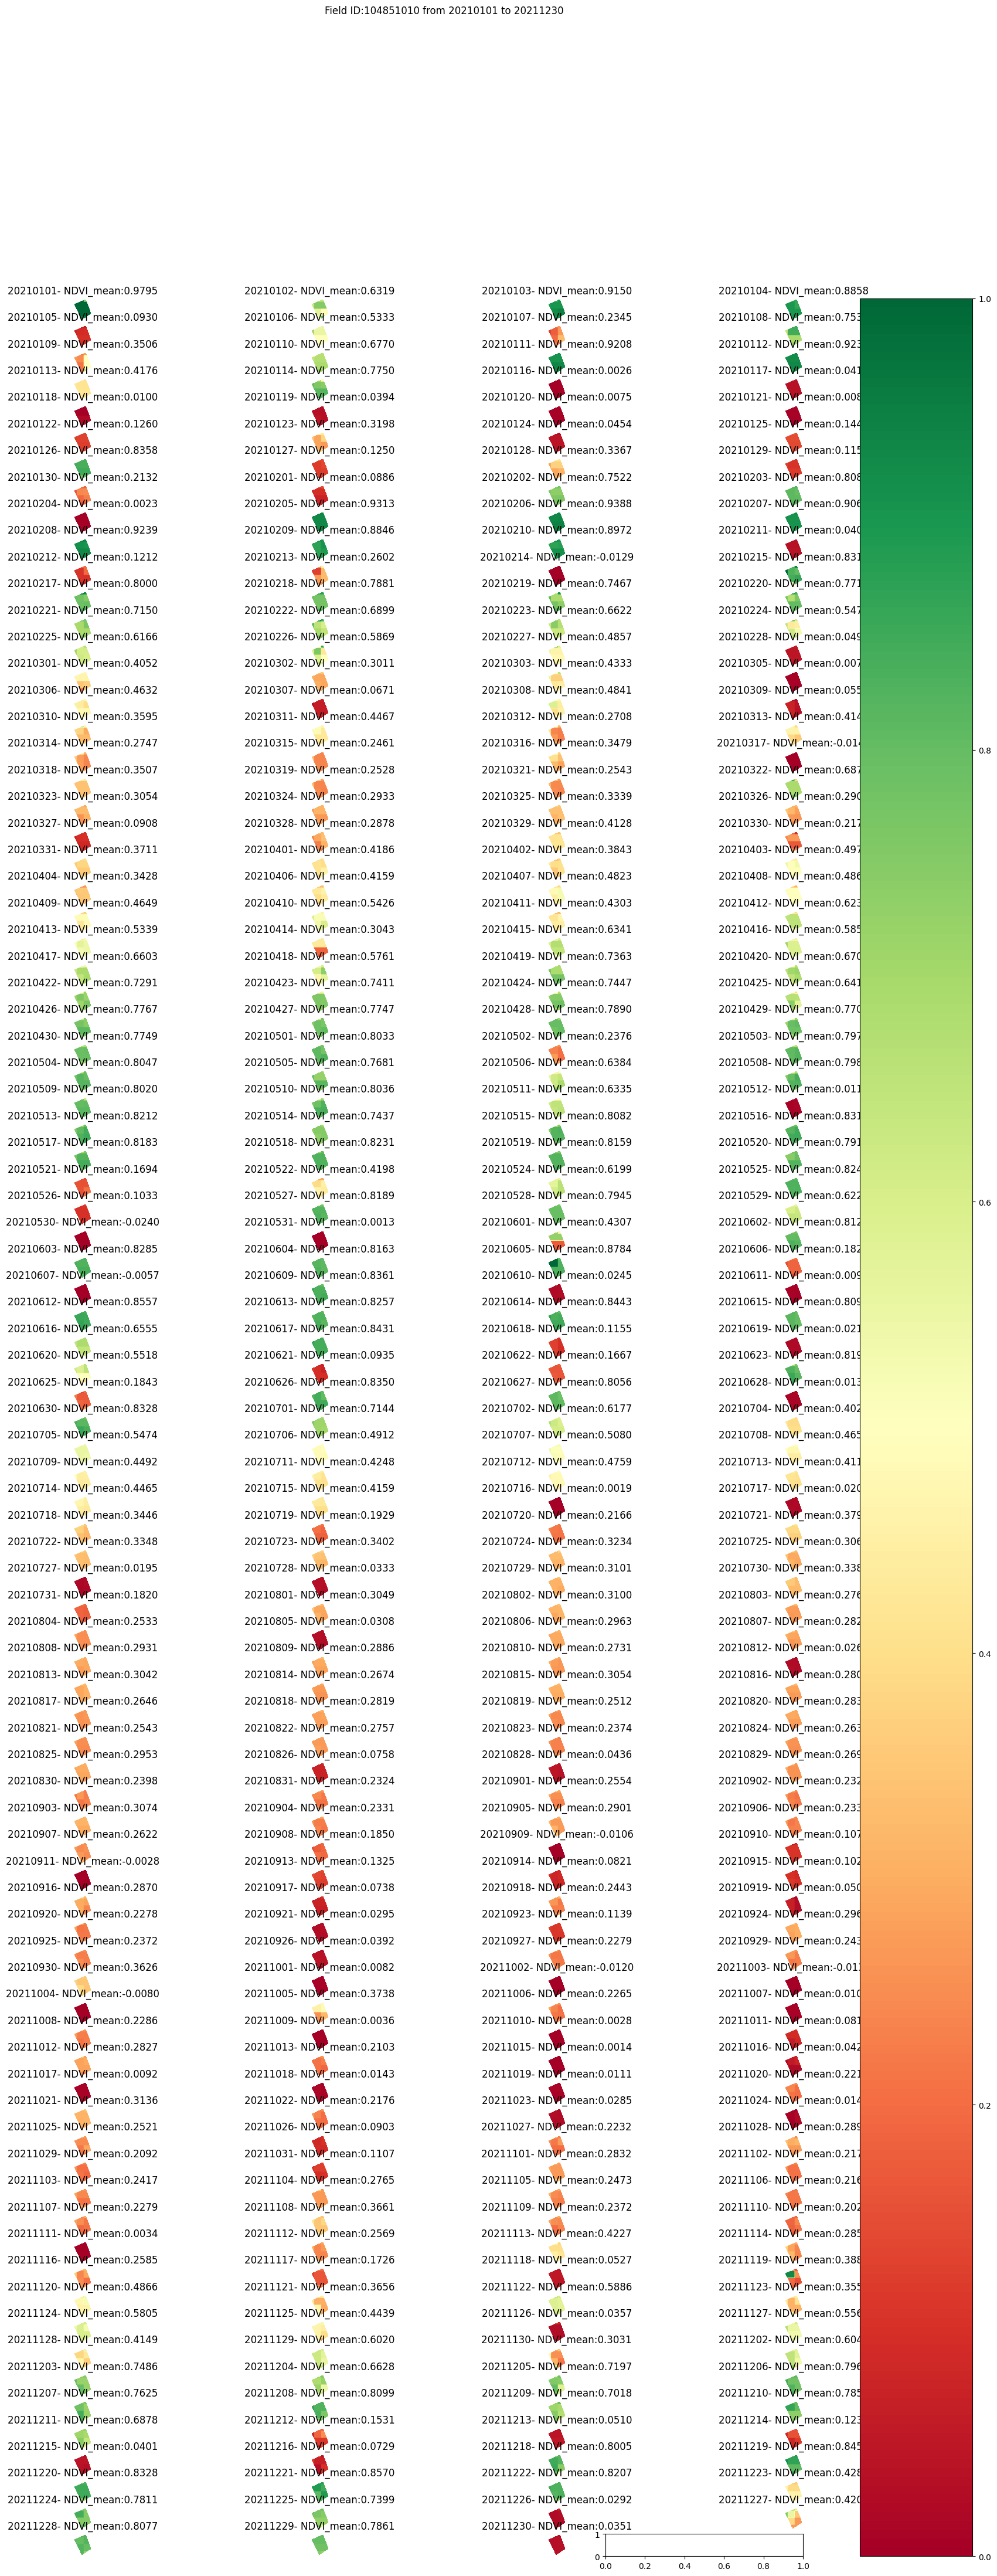

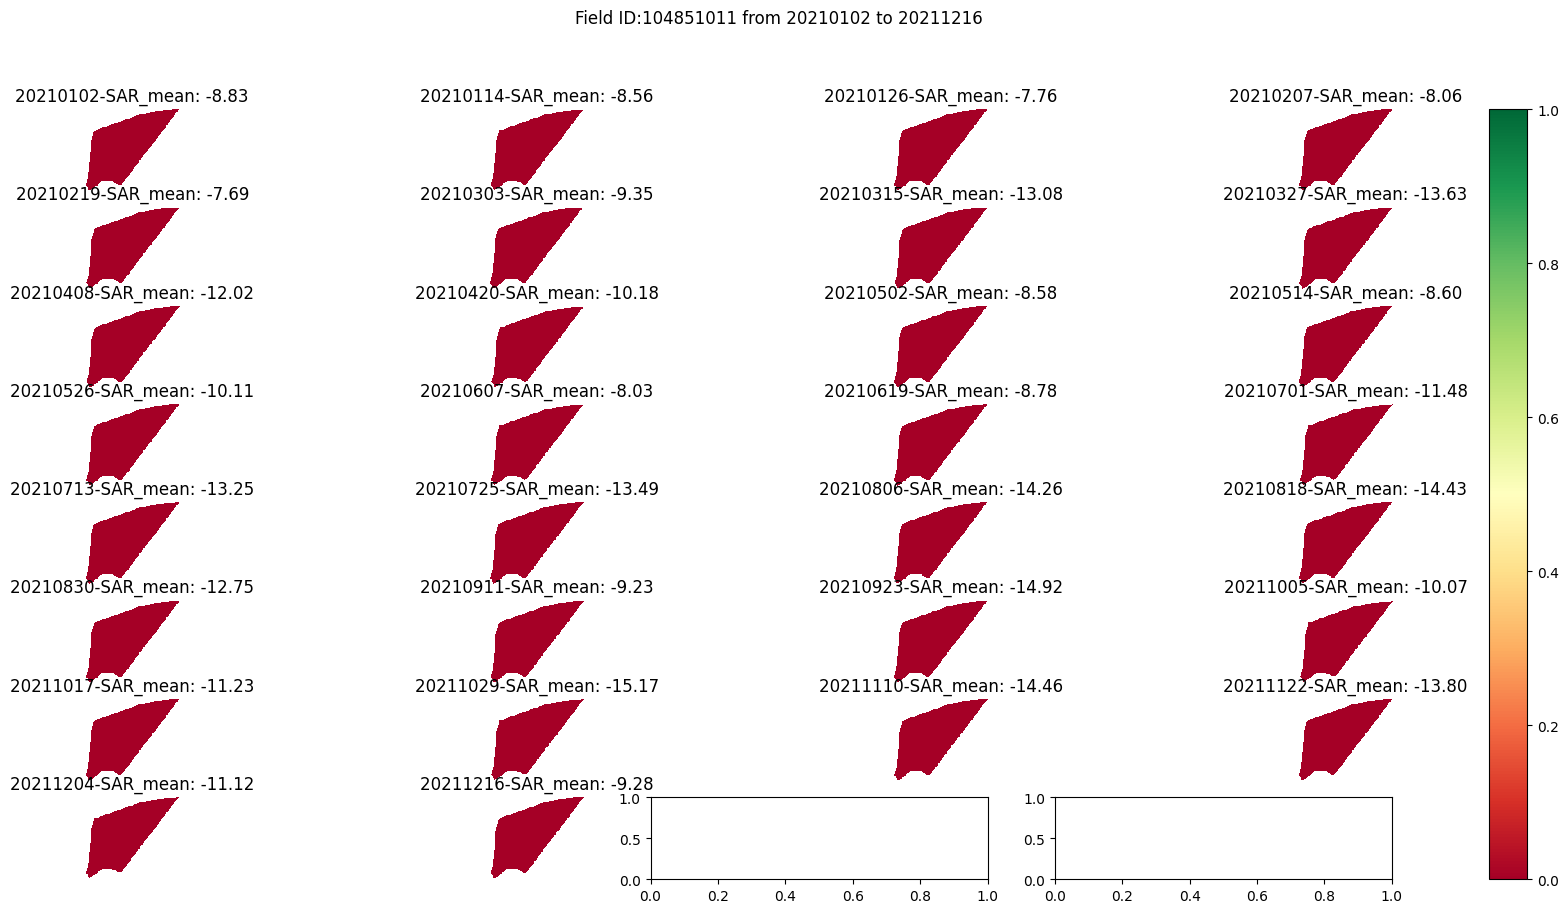

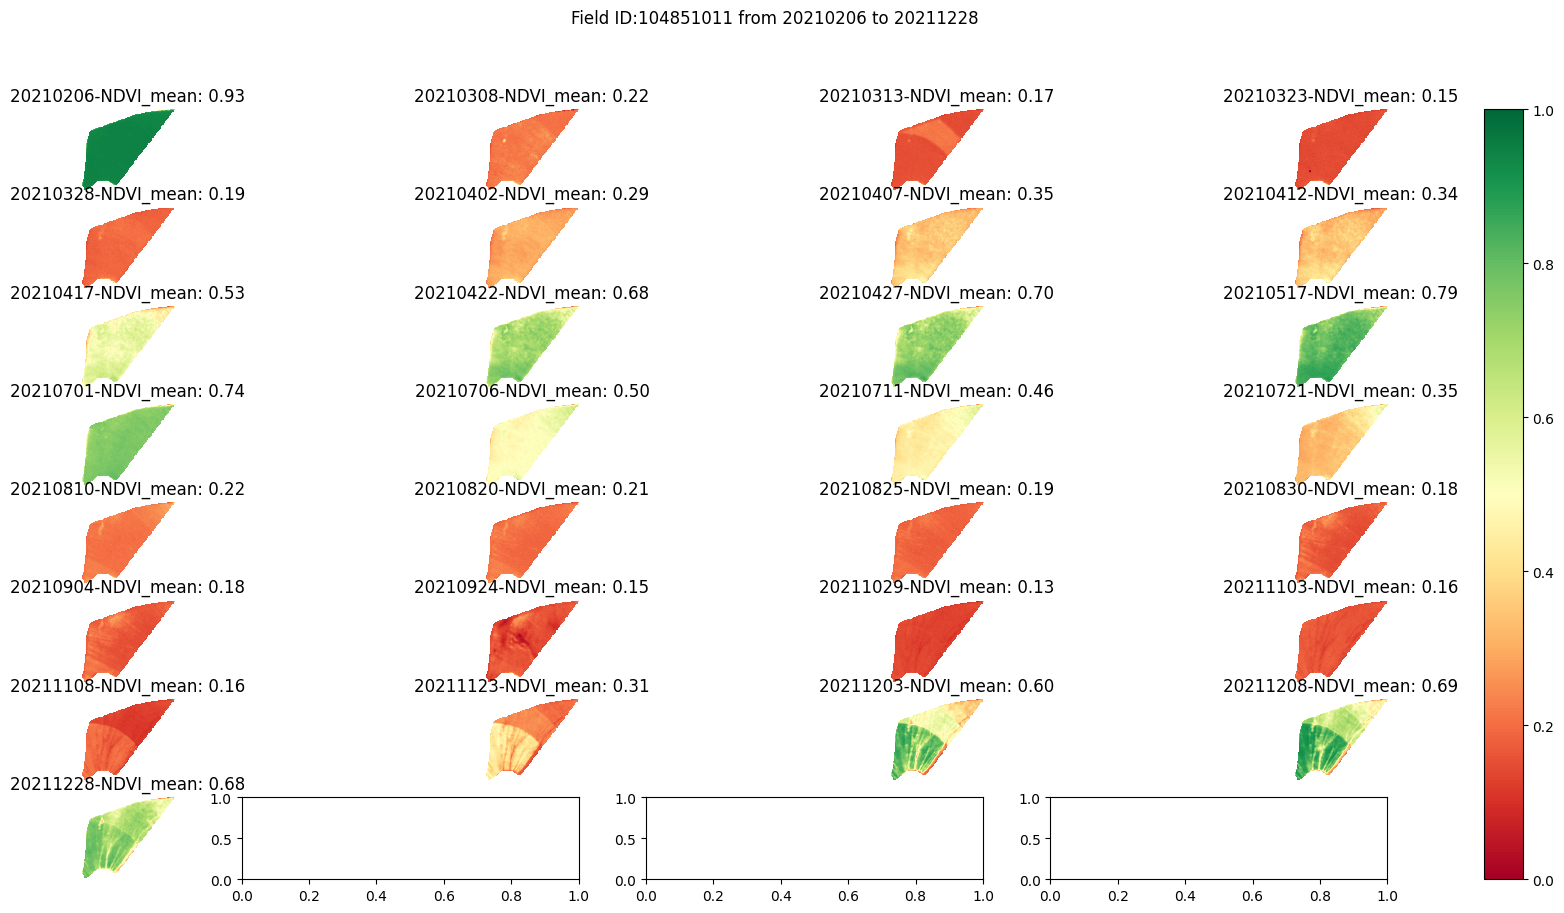

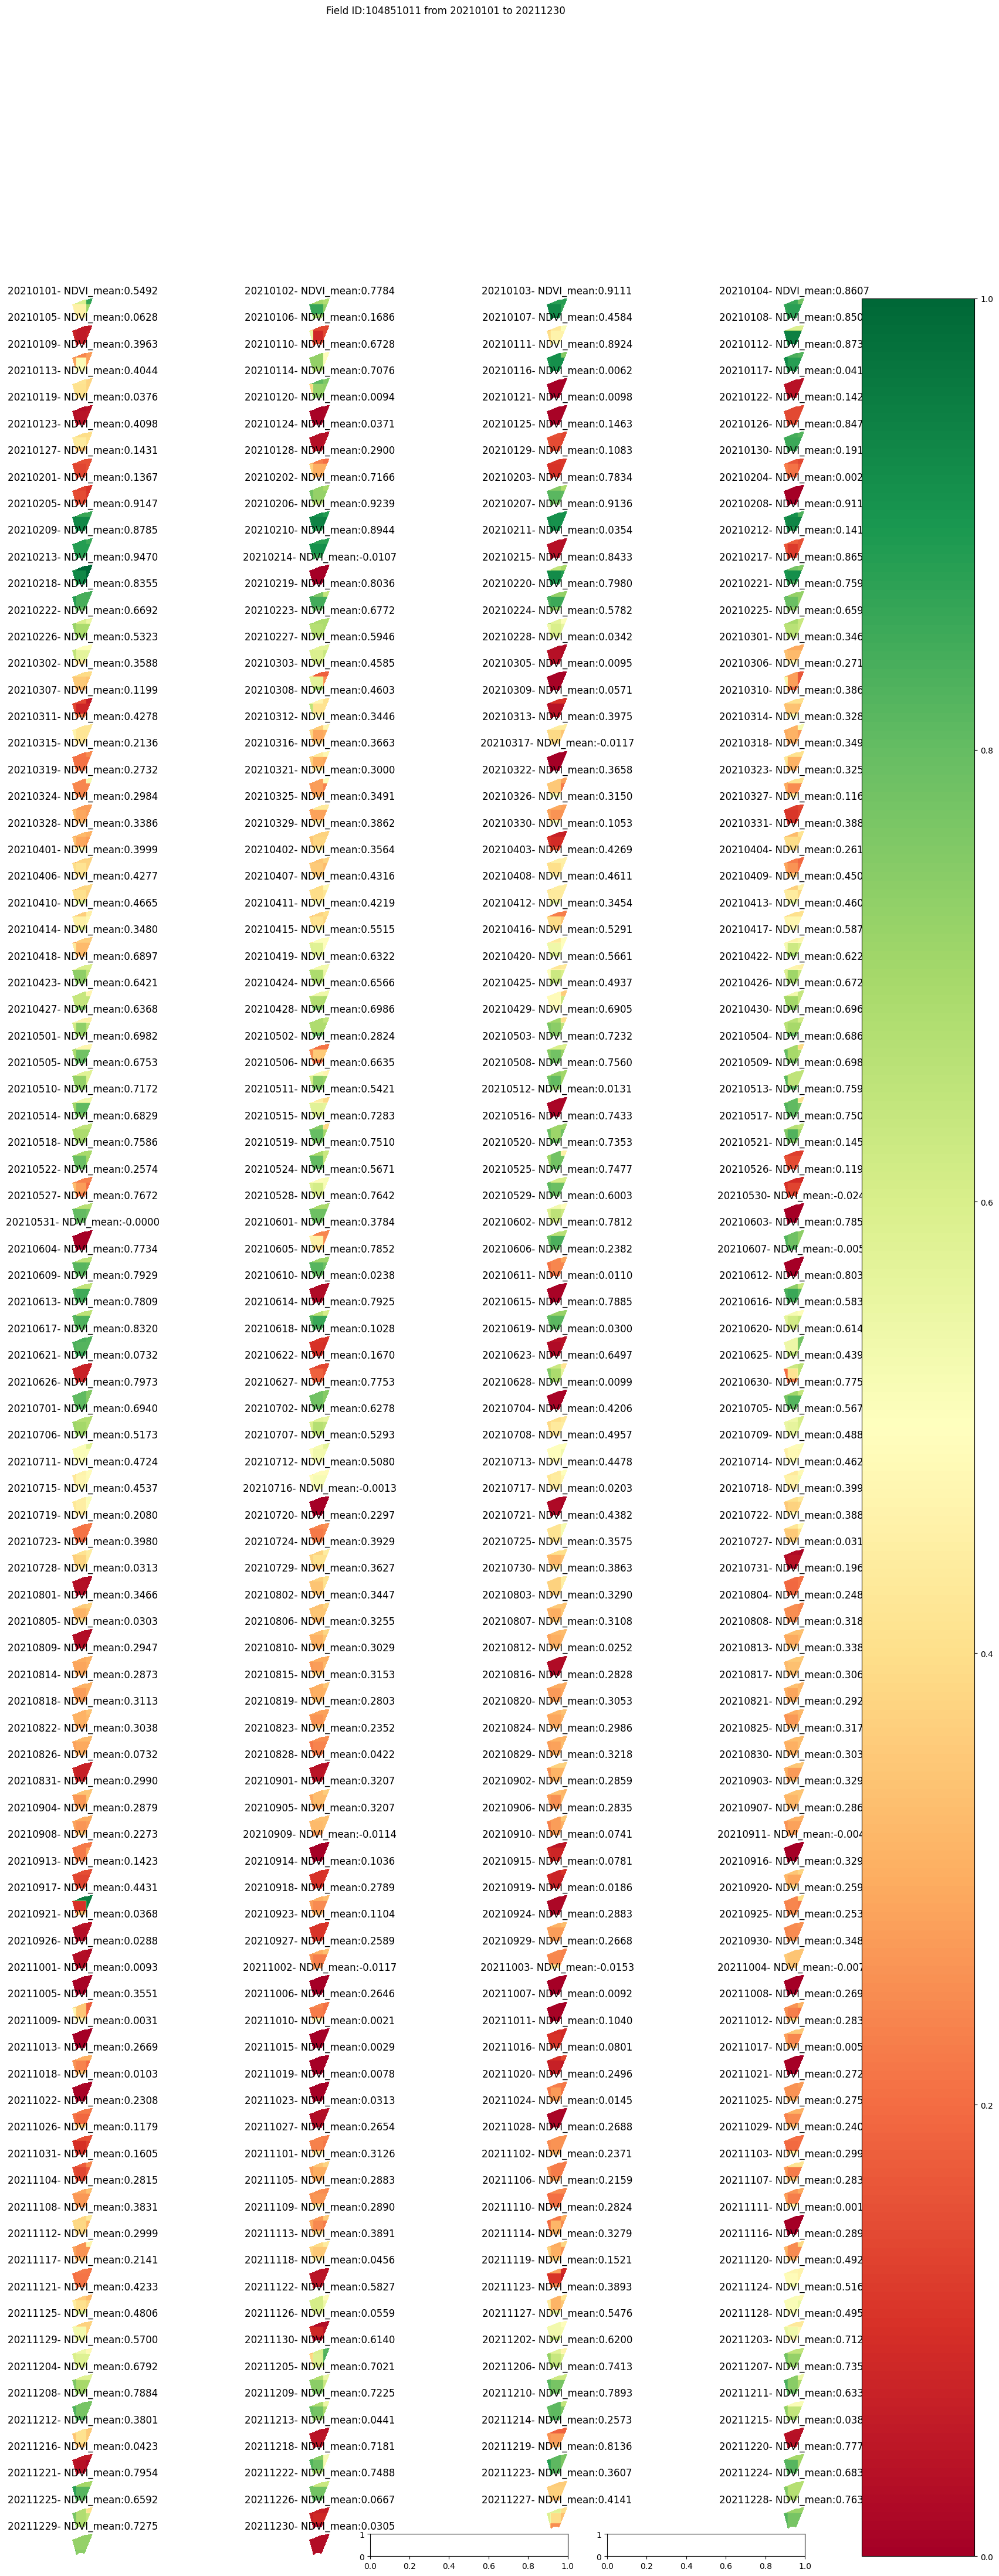

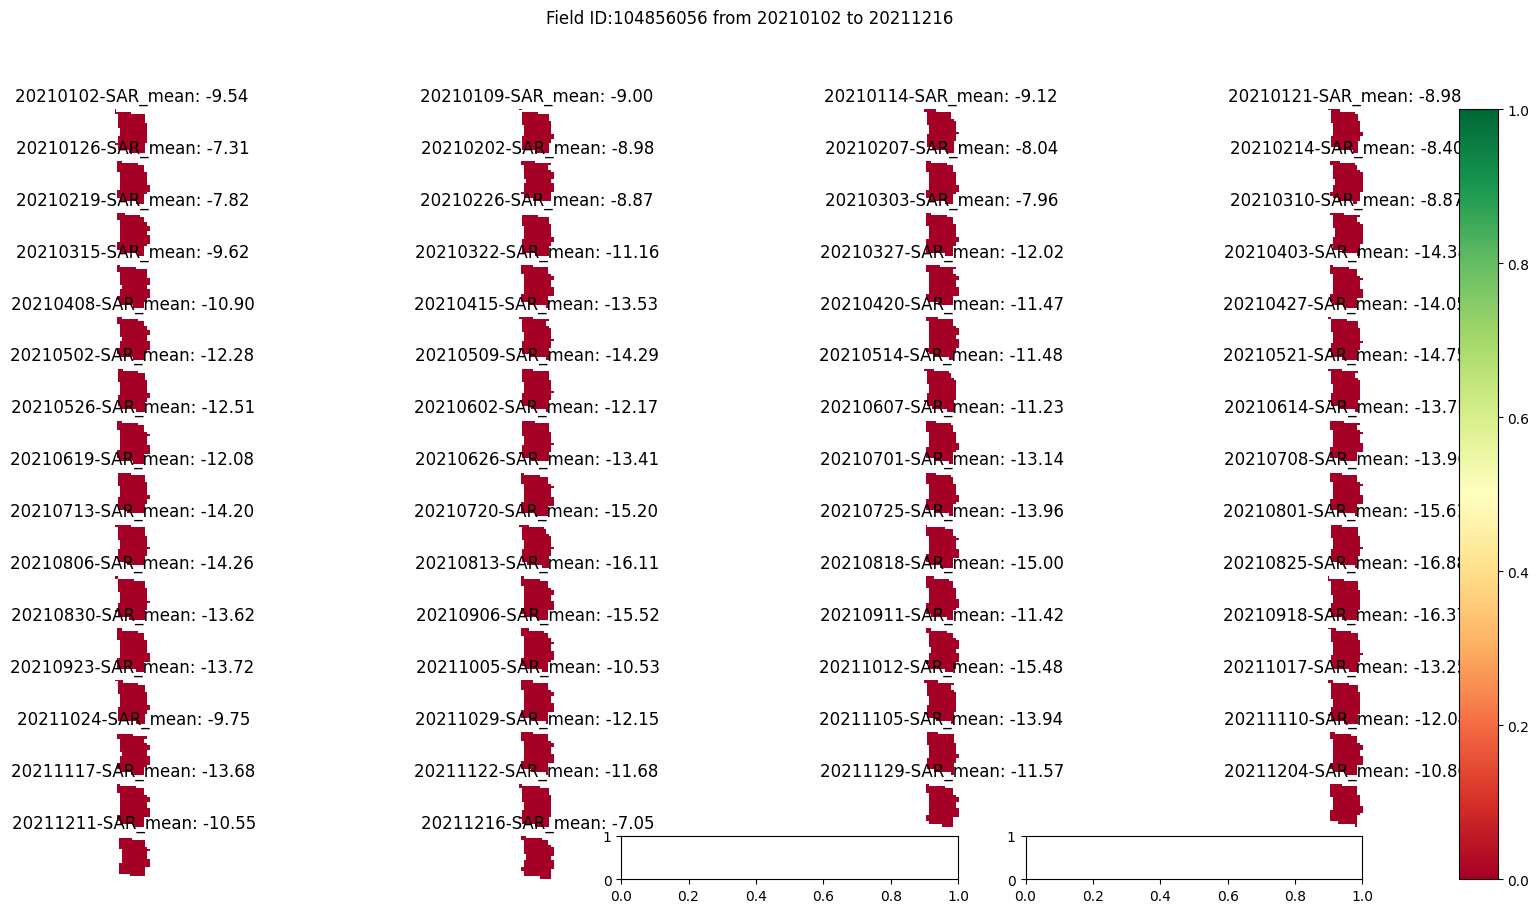

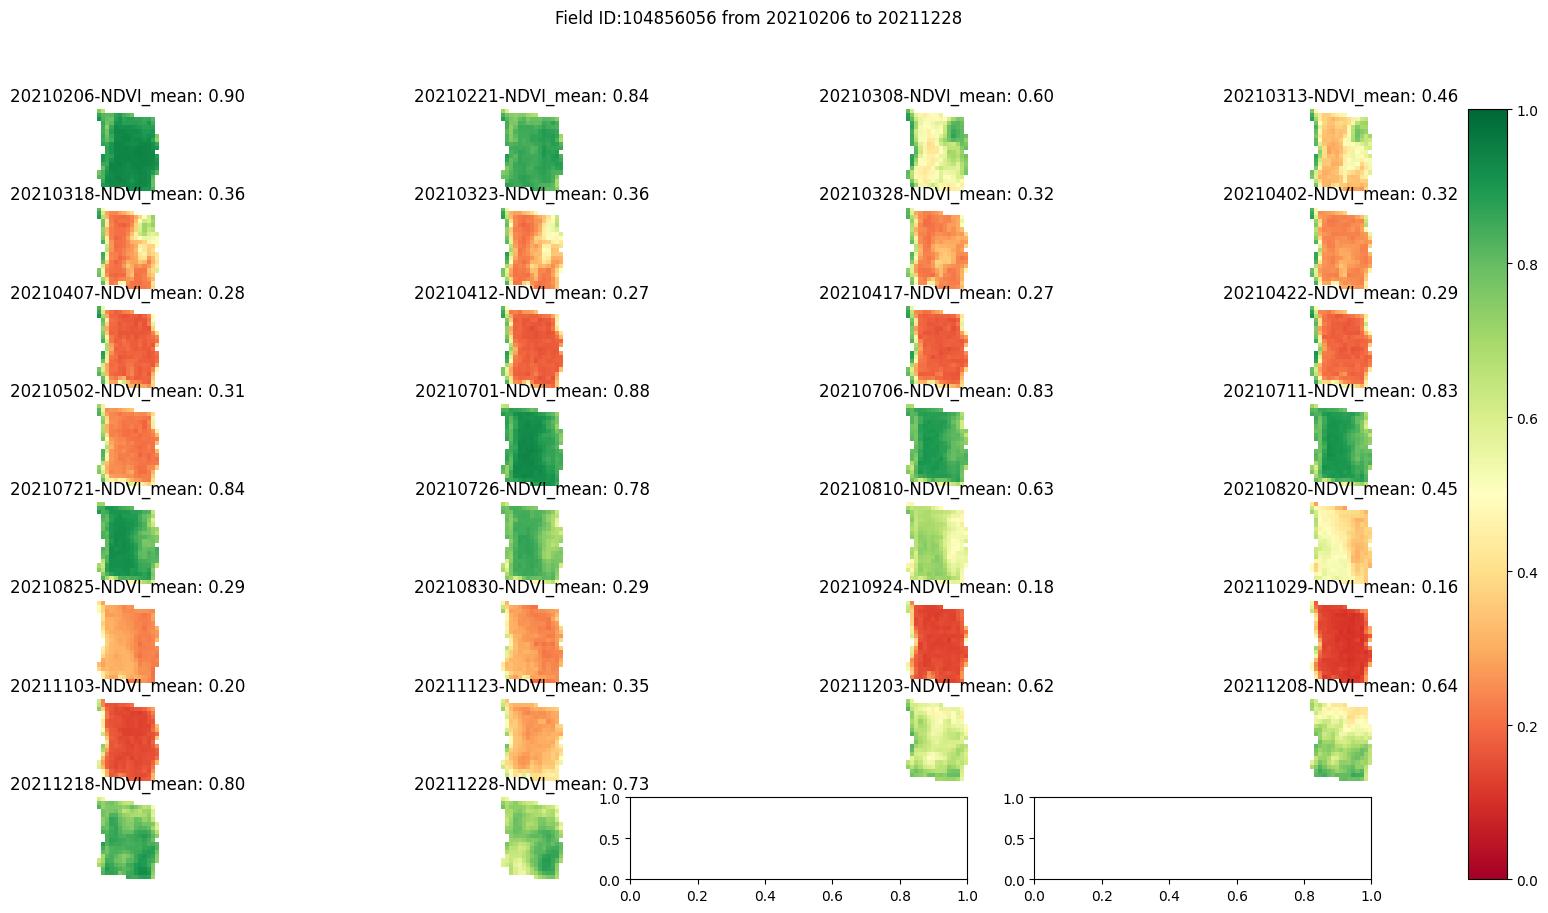

ValueError: Number of rows must be a positive integer, not 0

<Figure size 2500x5000 with 0 Axes>

In [29]:
year_choice = 2021
df_image = pd.DataFrame()
for sfd_id_choice in sfd_ids:
   # ---------- Step 1 : Data acquisition
   ## SAR (RVI value) 
    sar_tif_file = data_extractor(data_sar, sfd_id_choice, year_choice)   # 26    
    sar_tif_file = EliminateNonStandardSize(data_sar, sar_tif_file,year_choice)    
    SAR_numpy_des, SAR_numpy, SAR_DATE, SAR_mean, SAR_std, SAR_med, SAR_max, SAR_min = Generate_All_SAR_Image(data_sar,year_choice,sar_tif_file,savePath,close=True,save=False)    
    SAR_dict = {'Date':SAR_DATE,'SAR_numpy_des':SAR_numpy_des,'SAR_mean':SAR_mean,'SAR_std':SAR_std ,'SAR_med':SAR_med,'SAR_max':SAR_max,'SAR_min':SAR_min}
    SAR_df = pd.DataFrame(SAR_dict)
        
    ## Multispectral
    band_tif_file, ndvi_tif_file = Multispectral_data_extractor(data_image, sfd_id_choice, year_choice)
    ndvi_tif_file = EliminateNonStandardSize(data_image, ndvi_tif_file,year_choice) #### SAR RESCONTRUCTION here - 41
    band_tif_file = CorrespondingProcessing(ndvi_tif_file,band_tif_file)
    NDVI_numpy, NDVI_DATE, NDVI_mean, NDVI_std, NDVI_med = Generate_NDVI_Image(data_image,year_choice,ndvi_tif_file,savePath,close=True,save=False)
    NDVI_dict = {'Date':NDVI_DATE,'NDVI_numpy':NDVI_numpy,'NDVI_mean':NDVI_mean,'NDVI_std':NDVI_std ,'NDVI_med':NDVI_med}
    NDVI_df = pd.DataFrame(NDVI_dict)
    
    ## MODIS 
    modis_tif_file = data_extractor(data_modis, sfd_id_choice, year_choice)   # 364
    modis_tif_file = EliminateNonStandardSize(data_modis, modis_tif_file,year_choice) 
    modis_numpy, modis_DATE, modis_mean, modis_std, modis_med, modis_max, modis_min = Generate_MODIS_Image(data_modis,year_choice, modis_tif_file, savePath,close=True,save=False)
    modis_dict = {'Date':modis_DATE,'modis_numpy':modis_numpy,'modis_mean':modis_mean,'modis_std':modis_std ,'modis_med':modis_med,'modis_max':modis_max,'modis_min':modis_min}
    modis_df = pd.DataFrame(modis_dict)
    
    # SAR and NDVI Combination (Manually)
    # SAR_df['Date'].to_csv('SAR.csv',index=False)
    # NDVI_df['Date'].to_csv('NDVI.csv',index=False)
    # df = SAR_df.merge(NDVI_df,on='Date')
    # df_image = pd.concat([df_image,df])        

## Data Combination

In [250]:
# Data Combination - if not having the .csv file for matching Date b/w SAR and NDVI --> do it manually
df_image_dataset = LoadDate_DataAggregation(sfd_id_choice,year_choice,SAR_df,NDVI_df,modis_df,save=True)

In [255]:
#df_image_dataset

In [252]:
# After finishing with 3 years
df_dataset = DataFrameYearCombination(sfd_id_choice,save=True)

In [256]:
#df_dataset

In [258]:
# After finishing with all fields
df_dataset = Load_Dataset(sfd_ids,save=True)

## Data Injection

In [7]:
## all features
features = ['id','SAR_mean','SAR_std','SAR_med','SAR_max','SAR_min','modis_mean','modis_std','modis_med','modis_max','modis_min','year_id']
selected = ['field_id','year','Date','id','year_id','DoY','SAR_mean','SAR_std','SAR_med','SAR_max','SAR_min','modis_mean','modis_std','modis_med','modis_max','modis_min','NDVI_mean']

## 6 features
features = ['id','SAR_mean','SAR_std','SAR_med','modis_mean','modis_std','modis_med','year_id'] 
selected = ['field_id','year','Date','id','year_id','DoY','SAR_std','SAR_med','modis_mean','modis_med','NDVI_mean']

# one Field - modify the sfd_ids

# All dataset
df_dataset = Load_Dataset(sfd_ids,save=False)
df_dataset['Date'] = pd.to_datetime(df_dataset['Date'],format='%d%m%y')
df_dataset['year'] = df_dataset['Date'].dt.strftime('%Y')
df_dataset['year_id'] = df_dataset['Date'].dt.strftime('%Y')
# using DoY
df_dataset.insert(1, "DoY", df_dataset['Date'].apply(lambda x:x.dayofyear), True)
df_dataset['DoY'] = df_dataset['DoY']/365

# Using x.toordinal())
# df_dataset.insert(1, "DoY", df_dataset['Date'].apply(lambda x:x.toordinal()), True)
# features = ['DoY','id','SAR_mean','SAR_std','SAR_med','modis_mean','modis_std','modis_med','year_id'] 

## Data processing

In [8]:
df_filtered_dataset = DataFiltering(df_dataset)
df_scaled_filterd_dataset = FeatureScaling(df_filtered_dataset,features,save=False)#####
# df_smoothed_scaled_filterd_dataset = DataSmoothing(df_scaled_filterd_dataset,features[1:])
df_scaled_filterd_dataset

field_id  DoY   id       Date  SAR_mean  SAR_std  SAR_med  SAR_max  \
0    104839603 0.01 0.00 2019-01-13      0.49     0.46     0.50     3.10   
1    104839603 0.02 0.00 2019-01-25      0.58     0.64     0.55     2.67   
2    104839603 0.02 0.00 2019-02-01      0.64     0.55     0.63     2.37   
3    104839603 0.06 0.00 2019-03-09      0.17     0.33     0.16     2.90   
4    104839603 0.06 0.00 2019-03-14      0.06     0.12     0.06     1.63   
..         ...  ...  ...        ...       ...      ...      ...      ...   
337  104852841 0.86 1.00 2021-07-20      0.51     0.47     0.53     2.50   
338  104852841 0.90 1.00 2021-09-06      0.19     0.26     0.18     1.92   
339  104852841 0.96 1.00 2021-11-05      0.22     0.33     0.20     2.32   
340  104852841 0.97 1.00 2021-11-17      0.29     0.33     0.29     2.25   
341  104852841 0.99 1.00 2021-12-11      0.28     0.24     0.28     1.93   

     SAR_min  modis_mean  modis_std  modis_med  modis_max  modis_min  \
0       0.15        0.59       0.07       0.58       0.63       0.54   
1       0.16        0.55       0.04       0.54       0.52       0.46   
2       0.15        0.44       0.11       0.42       0.50       0.41   
3       0.07        0.51       0.12       0.49       0.62       0.46   
4       0.01        0.59       0.01       0.58       0.63       0.52   
..       ...         ...        ...        ...        ...        ...   
337     0.07        0.55       0.09       0.52       0.54       0.48   
338     0.07        0.41       0.11       0.37       0.43       0.33   
339     0.07        0.60       0.01       0.60       0.56       0.53   
340     0.07        0.08       0.02       0.08       0.15       0.11   
341     0.12        0.60       0.11       0.61       0.62       0.51   

     NDVI_mean  year  year_id  
0         0.49  2019     0.00  
1         0.38  2019     0.00  
2         0.25  2019     0.00  
3         0.15  2019     0.00  
4         0.16  2019     0.00  
..         ...   ...      ...  
337       0.59  2021     1.00  
338       0.17  2021     1.00  
339       0.18  2021     1.00  
340       0.26  2021     1.00  
341       0.51  2021     1.00  

[342 rows x 17 columns]

## Statistical Visualization

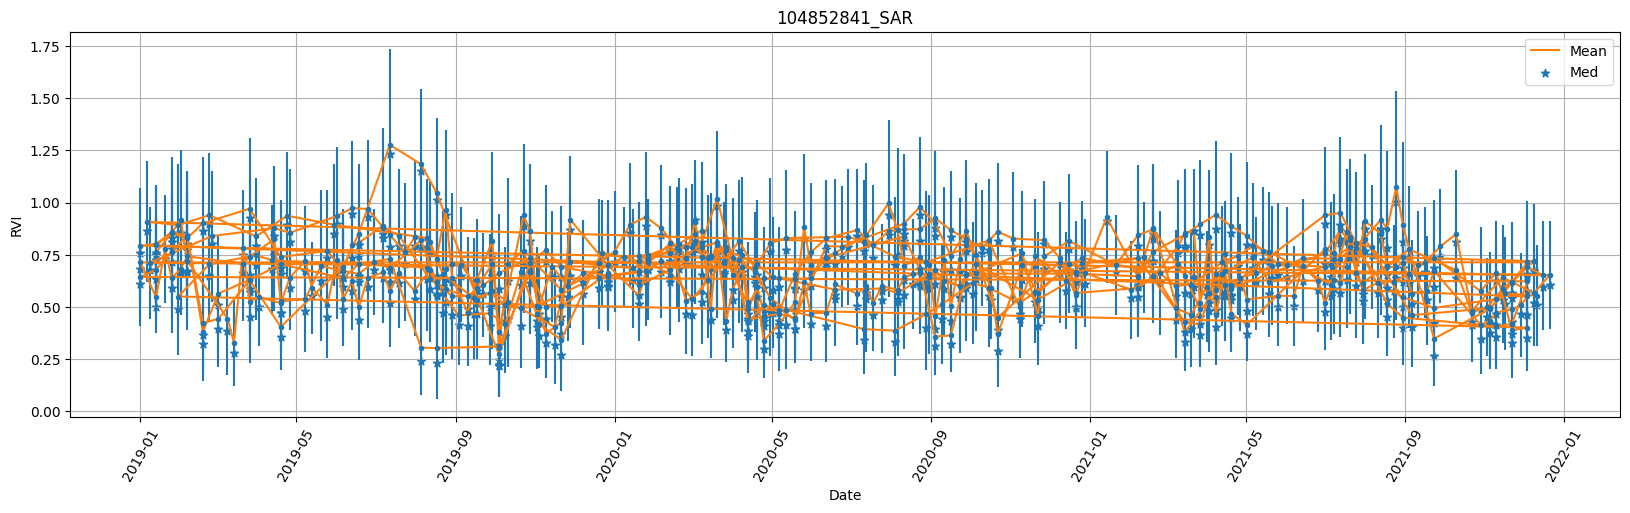

In [125]:
names = features[1:4]
StatisclVisualization(df_dataset,sfd_id_choice,names)

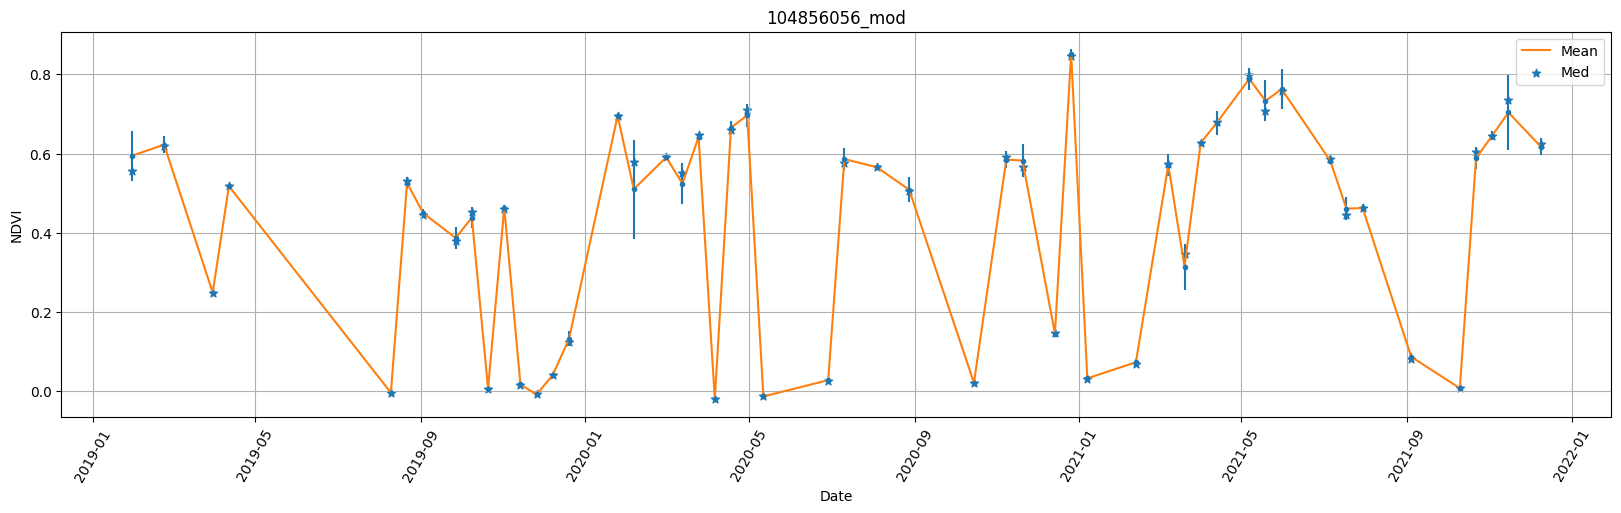

In [40]:
names = features[4:]
StatisclVisualization(df_dataset,sfd_id_choice,features[3:])

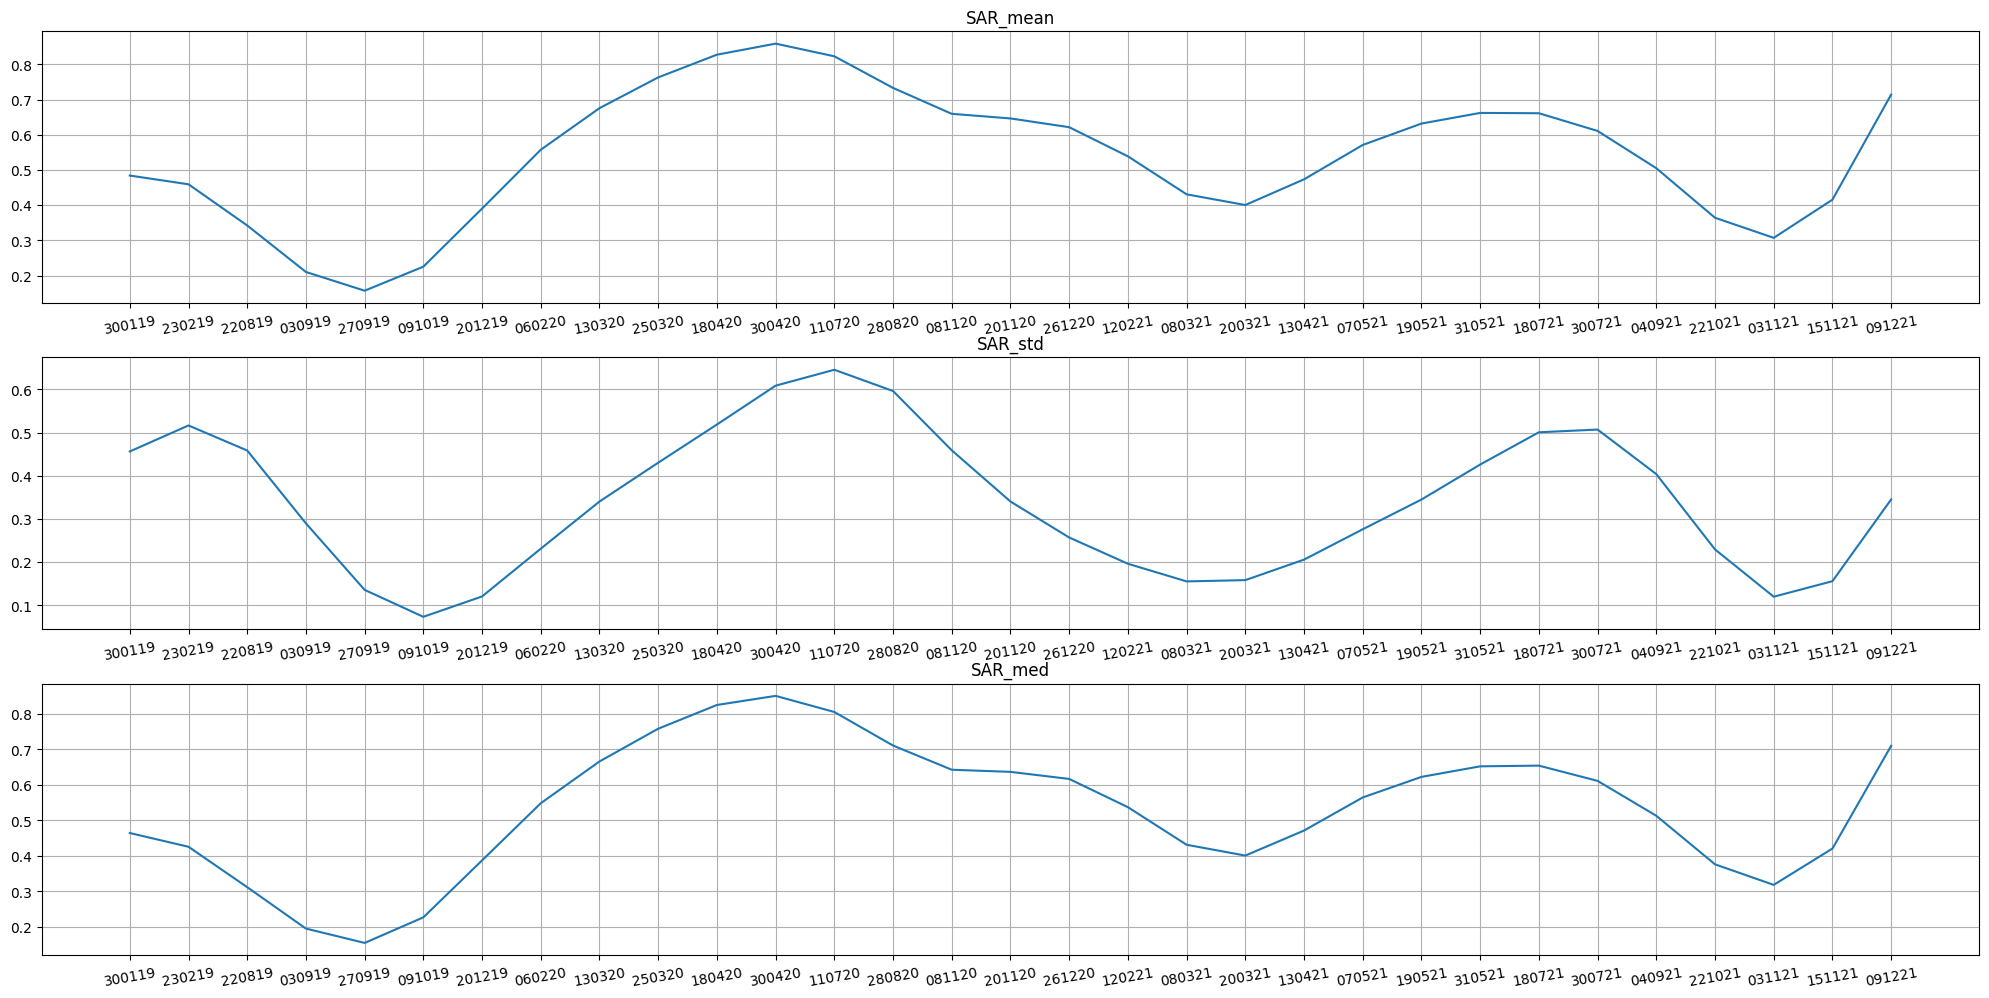

In [43]:
names = ['SAR_mean','SAR_std','SAR_med']
StatiscalLine(df_smoothed_scaled_filterd_dataset,sfd_id_choice,names,save=False)

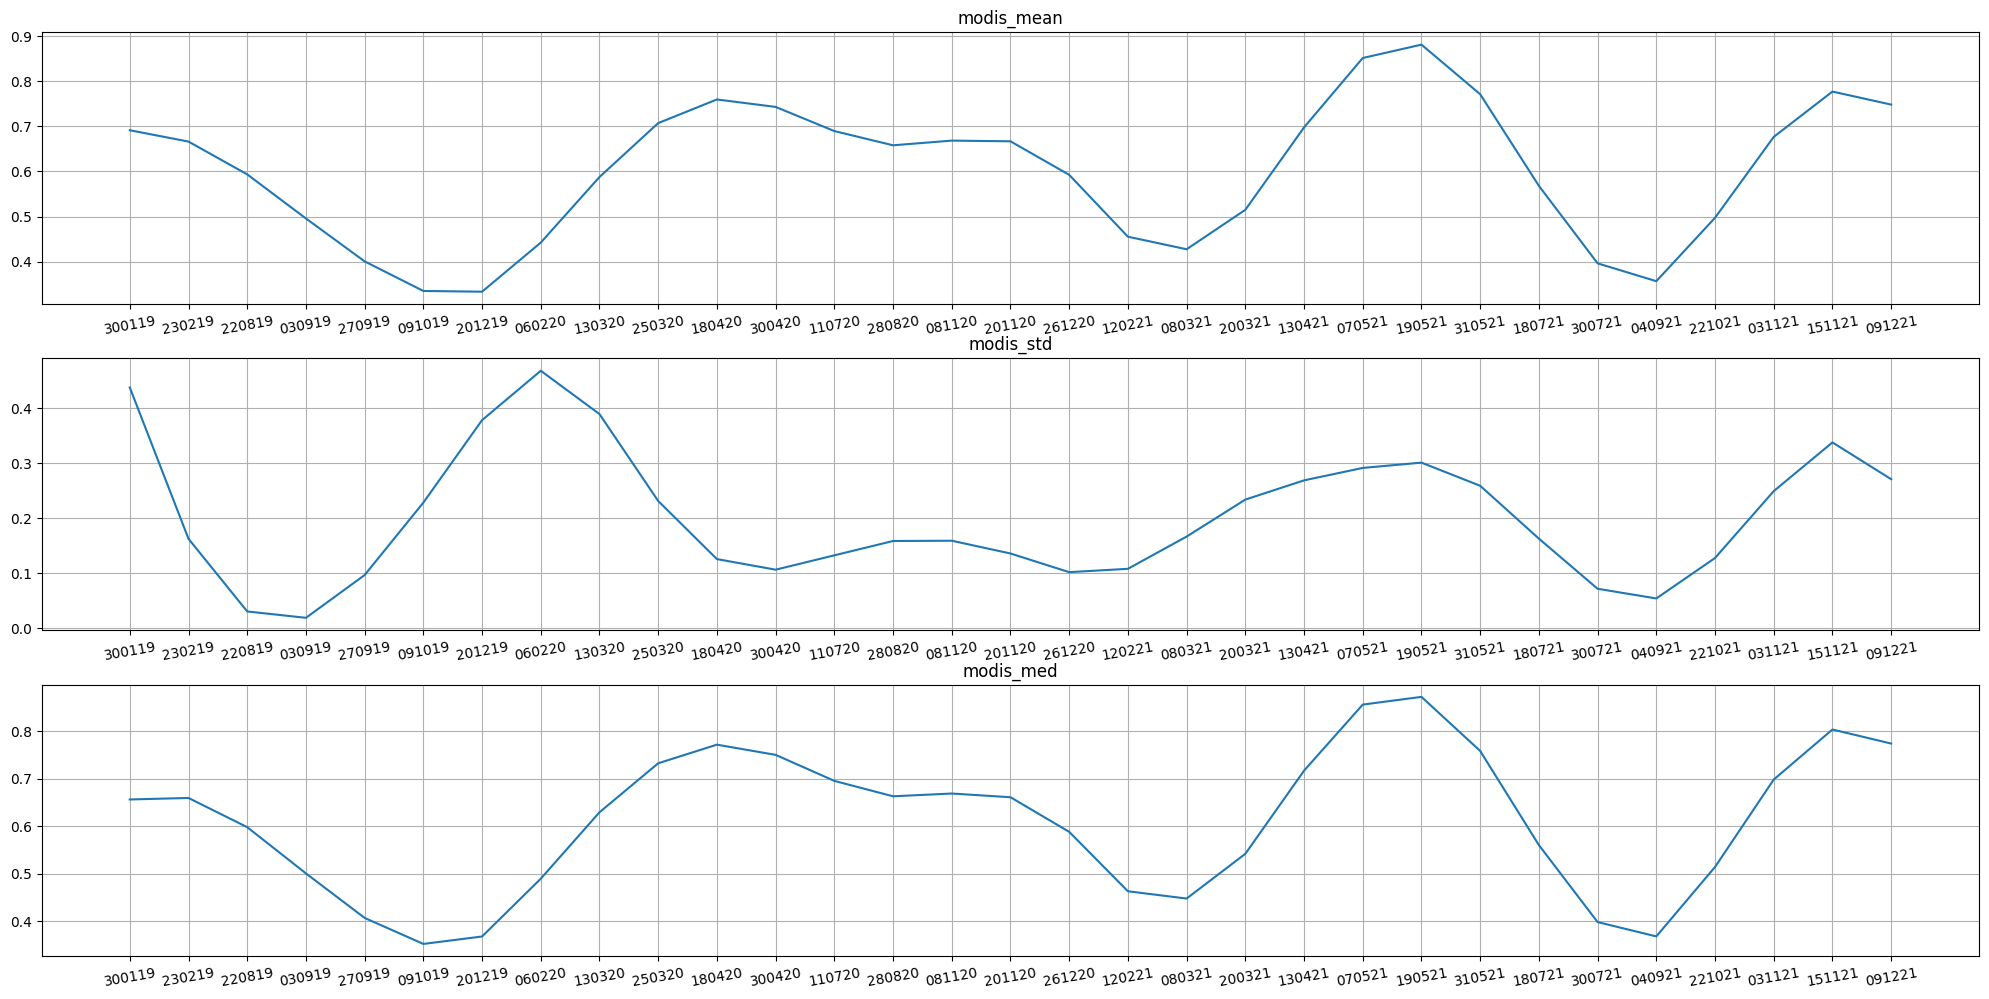

In [44]:
names = ['modis_mean','modis_std','modis_med']
StatiscalLine(df_smoothed_scaled_filterd_dataset,sfd_id_choice,names,save=False)

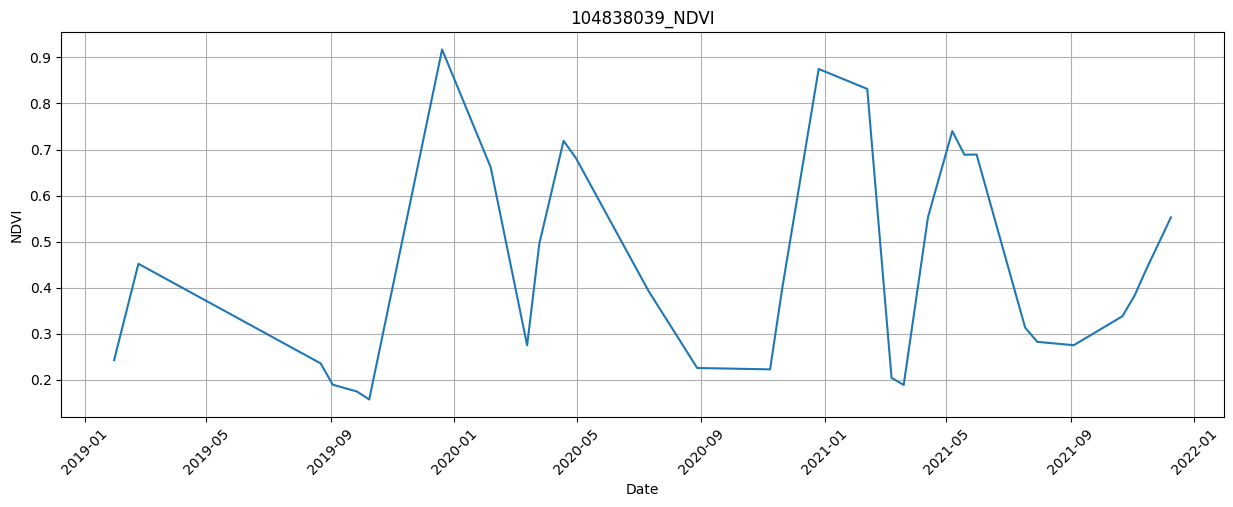

In [50]:
NDVI_plot(df_smoothed_scaled_filterd_dataset,sfd_id_choice)

In [60]:
## Building Histogram
# x = NDVI_Der_df['NDVI_numpy'][0]
# x = x[~x.mask]
# plt.hist(x, bins=5)

# Data Modeling

In [9]:
from sklearn.model_selection import train_test_split
import xgboost as xg
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor
from sklearn.feature_selection import RFECV
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import pickle

WORKFLOW FOR ML(8 MAIN STEP) : (for Builing models)
- Defind the problem (Regression) and assembling a dataset (from GE)
- Choosing a measure of succes (Root - MSE and MAE)
- Evaluation protocal (K-*crossvalidation,... )
- Preparing the data (Data processing- using LEE despeckling for SAR)
- Develop the base model (for 1st working- RFR/XGBoost/SVR/Stack)
- HyperParameters Tuning + Consider model evaluation
- Sacling up (make model get overfit ) -> Increasing the dataset
- Regularization (overcome the overfit)

In [10]:
selected = ['field_id','year','Date','id','DoY','SAR_std','SAR_med','modis_mean','modis_med','NDVI_mean']

In [11]:
preprocessed_dataset = df_scaled_filterd_dataset[selected]
# preprocessed_dataset = df_smoothed_scaled_filterd_dataset[selected]
preprocessed_dataset

field_id  year       Date   id  DoY  SAR_std  SAR_med  modis_mean  \
0    104839603  2019 2019-01-13 0.00 0.01     0.46     0.50        0.59   
1    104839603  2019 2019-01-25 0.00 0.02     0.64     0.55        0.55   
2    104839603  2019 2019-02-01 0.00 0.02     0.55     0.63        0.44   
3    104839603  2019 2019-03-09 0.00 0.06     0.33     0.16        0.51   
4    104839603  2019 2019-03-14 0.00 0.06     0.12     0.06        0.59   
..         ...   ...        ...  ...  ...      ...      ...         ...   
337  104852841  2021 2021-07-20 1.00 0.86     0.47     0.53        0.55   
338  104852841  2021 2021-09-06 1.00 0.90     0.26     0.18        0.41   
339  104852841  2021 2021-11-05 1.00 0.96     0.33     0.20        0.60   
340  104852841  2021 2021-11-17 1.00 0.97     0.33     0.29        0.08   
341  104852841  2021 2021-12-11 1.00 0.99     0.24     0.28        0.60   

     modis_med  NDVI_mean  
0         0.58       0.49  
1         0.54       0.38  
2         0.42       0.25  
3         0.49       0.15  
4         0.58       0.16  
..         ...        ...  
337       0.52       0.59  
338       0.37       0.17  
339       0.60       0.18  
340       0.08       0.26  
341       0.61       0.51  

[342 rows x 10 columns]

## Function

In [15]:
def DataSplitting_randomly(df):
    # Old Method 
    # DataSplitting_randomly(df_scaled_filterd_dataset)
    X = (df.iloc[:,1:-1]).astype('float')
    y = (df.iloc[:,-1]).astype('float')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

def DataSplitting(df,sfd_ids,years,TestRatio = 0.1,random_state=0) :
    '''    
    Split the dataset:
    TrainingSet: keep all samples from the past to the last year
    TestingSet: separate only the last year according to the Test Ratio
    ----------
    Attributes:
    df : pd.DataFrame
        dataset having ['field_id','year'] and ['DoY']
    sfd_ids: list of fields 
    ----------
    Returns:        
    X_train, y_train: pd.DataFrame 
    X_test, y_test: pd.DataFrame    
    ----------
    Example:    
    sfd_ids= ['','']
    years = ['2019','2020','2021']
    X_train, X_test, y_train, y_test = DataSplitting(df_scaled_filterd_dataset,sfd_ids,years,TestRatio = 0.1,random_state=0)
    '''
    df = df.reset_index()
    df = df.set_index(['field_id','year','index']) 
    df_train = pd.DataFrame()
    df_test = pd.DataFrame()
    for sfd_id_choice in sfd_ids:
        df_2_last_year = pd.DataFrame()
        for year in years[:-1]:            
            df_2_last_year = pd.concat([df_2_last_year,df.loc[(sfd_id_choice,year),:]])        
        df_lastyear = df.loc[(sfd_id_choice,years[-1]),:]
        df_len = len(df.loc[sfd_id_choice])
        test_size = int(np.ceil(df_len*TestRatio))
        df_test_lastyear = df_lastyear.sample(n=test_size, random_state=random_state)
        DoY_lastyear = df_test_lastyear['DoY'].values.tolist()
        to_delete=[]
        for idx,row in df_test_lastyear.iterrows():
            if row['DoY'] in DoY_lastyear:
                to_delete.append(idx)    
        df_train_lastyear = df_lastyear.drop(to_delete,axis=0)    
        df_train = pd.concat([df_train,df_2_last_year,df_train_lastyear]).reset_index(drop=True)
        df_test = pd.concat([df_test,df_test_lastyear]).reset_index(drop=True)
    X_train = (df_train.iloc[:,1:-1]).astype('float')
    y_train = (df_train.iloc[:,-1]).astype('float')
    X_test = (df_test.iloc[:,1:-1]).astype('float')
    y_test = (df_test.iloc[:,-1]).astype('float')
    return X_train, X_test, y_train, y_test

# Model Evaluation
def FeaImpPlot(columns,weights):
    '''    
    Plot the feature importances of the tree-based models
    ----------
    Attributes:
    columns: List
        List of features of the figure
    weights: np.array
        The value array of the weights
    ----------
    Example:    
    FeaImpPlot(X.columns,model.feature_importances_)
    '''    
    # 
    plt.figure(figsize = (14,5))
    plt.bar(columns, weights)
    plt.xlabel('Features')
    plt.ylabel('Weight')
    plt.grid()
    plt.title('Feature Importances')
    
def test_validation(model,X_test,y_test,GP=False):
    '''    
    Create the test dataframe plus show the RMSE score between the observation and prediction
    Target less than 10%
    ----------
    Attributes:
    model : model
    X_test: pd.DataFrame
    y_test: pd.DataFrame
    ----------
    Returns:    
    test_df : pd.DataFrame
        Test Dataframe    
    ----------
    Example:    
    test_df, acc = test_validation(model,X_test,y_test)
    '''
    def BinaryTransform(Input):
        if Input > 0.1:
            res = 1
        else: 
            res = 0
        return res
    if GP:
        with torch.no_grad():
            # Gaussian Prediction
            test_x = torch.tensor(np.array(X_test))
            model.eval()
            likelihood.eval()
            observed_pred = likelihood(model(test_x)) 
            y_pred = observed_pred.mean.detach().numpy()
    else:
        y_pred = model.predict(X_test)
        
    test_dict = {'y_test':np.array(y_test),'y_pred':y_pred}
    test_df = pd.DataFrame(test_dict)
    test_df['diff'] = abs(test_df['y_test']-test_df['y_pred'])
    test_df['>0.1'] =  test_df['diff'].apply(BinaryTransform)
    fail_score = test_df['>0.1'].sum()
    acc = fail_score/len(test_df)
    # print('Test R2 score: {}'.format(r2_score(y_test,y_pred)))
    print('Test RMSE score: {:.2f}'.format(mean_squared_error(y_test, y_pred,squared=False)))
    print('Test MAE score: {:.2f}'.format(mean_absolute_error(y_test, y_pred)))
    print(f'The N.o samples larger than 0.1: {fail_score}')
    print(f'The Unacceptable Ratio: {acc:.2f}')
    return test_df, acc

def FeatureSelection(model,X_train,y_train,min_features_to_select=5):
    '''    
    Select the features of the model
    ----------
    Attributes:
    model : sklearn model
        model    
    X_train, y_train: pd.DataFrame
    ----------
    Example:
    FeatureSelection(model,X_train,y_train)
    '''    
    cv = KFold(n_splits=5, shuffle= True, random_state = 1)
    rfe = RFECV(model, min_features_to_select=5, step =1,cv=cv)
    rfe.fit(X_train,y_train)
    print (X_train.columns)
    print(rfe.support_)   

def HyperTuningPlot(para_list,score_text,score_train):
    
    '''
    para_list = C_list
    TuningPlot(para_list,score_text,score_train)
    '''
    plt.figure(figsize=(10,5))
    plt.plot(para_list,score_text, color='blue',  label='test_accuracy')
    plt.plot(para_list,score_train, color='red',  label='val_accuracy')
    plt.xlabel("para")
    plt.ylabel("RMSE")
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    print("The optimal parameter",C_list[score_text== min(score_text)])

def TrainingModel(untrained_model,X_train,y_train,scoring):
    '''
    model = RandomForestRegressor(n_estimators=36, max_depth=16,random_state=0)
    model.fit(X_train,y_train)
    cv = KFold(n_splits=5, shuffle= True, random_state = 1)
    scoring = 'neg_root_mean_squared_error'

    Val_score=  cross_val_score(estimator=model, X=X_train, y=y_train,cv=cv,scoring = scoring)
    score = Val_score.mean()
    print(f'Val Loss: {-score:.2f}')
    test_df, acc = test_validation(model,X_test,y_test)
    # test_df
    '''
    cv = KFold(n_splits=5, shuffle= True, random_state = 1)    
    model = untrained_model.fit(X_train,y_train)    
    # https://scikit-learn.org/stable/modules/model_evaluation.html    
    Val_score=  cross_val_score(estimator=model, X=X_train, y=y_train,cv=cv,scoring = scoring)
    score = Val_score.mean()
    print(f'Val Loss: {-score:.2f}')
    return model, score

    
def SaveModel(model,savePath,title):
    '''    
    Save Model
    ----------
    Attributes:
    model : model from ML
    save_path: saving repository
    title: str  
    ----------     
    Example:    
    SaveModel(model,savePath,'RFR_8field_Tuned_model.sav')
    '''    
    if not os.path.exists(f'{savePath}/model'):
        os.makedirs( f'{savePath}/model')
    filename = f'{savePath}/model/{title}'
    pickle.dump(model, open(filename, 'wb'))        
    
def loadModel(loadPath,title):
    '''    
    Load Model
    ----------
    Attributes:
    loadPath: loading repository
    title: str  
    ----------     
    Example:    
    loaded_model = loadModel(savePath,'RFR_8field_Tuned_model.sav')
    '''    
    filename = f'{savePath}/model/{title}'
    return pickle.load(open(filename,'rb'))

def Pred_Obs_plot(df_dataset,sfd_id_choice,model,feature_selected,acc,years=None,GB=False,Confident_drawing=False,save=False):
    '''    
    Plot the label of dataset and its prediction (NDVI_mean)
    ----------
    Attributes:
    df_dataset : pd.DataFrame
        Dataset dataframe    
    sfd_id_choice: 
        Chosed field
    model: sklearn model
    feature_selected: list
        list of featured selects
        feature_selected = ['id','DoY','SAR_std','SAR_med','modis_mean','modis_med']
    years: list
        chosed years for prediction
    save: bool, default=False
        Save the figure
    ----------
    Example:
    Pred_Obs_plot(df_dataset,sfd_id_choice,model,selected[3:-1],acc,GB=False,years=None,save=False)
    '''    
    df_dataset = df_dataset.set_index(['field_id','year'])    
    plt.figure(figsize =(15,5))
    title = f'{sfd_id_choice}_NDVI_means_Acc:{acc:.2f}'
    plt.title(title)
    Date = df_dataset.loc[sfd_id_choice,'Date']
    NDVI = df_dataset.loc[sfd_id_choice,'NDVI_mean']
    
    #HighlightedDate = df_dataset.loc[(sfd_id_choice,'2021'),'Date'].to_list()[0]
    d = datetime(2021,1,1)
    if years == None:
        df_4_predict = df_dataset.loc[sfd_id_choice,feature_selected]
        Date_pred = Date
        plt.axvline(x=d, c='r', lw=2, linestyle='dashed')
    else:
        df_4_predict = df_dataset.loc[(sfd_id_choice,years),feature_selected]
        Date_pred = df_dataset.loc[(sfd_id_choice,years),'Date']  
    
    if GB:
        with torch.no_grad():
        # Gaussian Prediction
            test_x = torch.tensor(np.array(df_4_predict))
            model.eval()
            likelihood.eval()
            observed_pred = likelihood(model(test_x)) 
            pred = observed_pred.mean.detach().numpy()
            if Confident_drawing:                
                lower, upper = observed_pred.confidence_region()                
                plt.fill_between(Date_pred, lower.numpy(), upper.numpy(), alpha=0.25,label='95% Credible Set')         
    else:
        pred = model.predict(df_4_predict)
    
    df_4_predict['pred'] = pred
    plt.plot(Date,NDVI,label='Observation')
    plt.plot(Date_pred,pred,label='Prediction')    
    plt.grid()
    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.ylabel('NDVI')
    plt.legend()
    plt.ylim([0, 1])
    if save:
        if not os.path.exists(f'{savePath}/'):
            os.makedirs( f'{savePath}/')        
        plt.savefig(f'{savePath}/{title}.png')
    return df_4_predict

## Data Splitting

In [16]:
years = ['2019','2020','2021']
X_train, X_test, y_train, y_test = DataSplitting(preprocessed_dataset,sfd_ids,years,TestRatio = 0.1,random_state=0)

## Old Model

### Data Modeling- XGBoost

In [269]:
model = xg.XGBRegressor(n_estimators=150, max_depth=3, eta=0.01,gamma=0)
scoring = 'neg_root_mean_squared_error'
model = TrainingModel(model,X_train,y_train,scoring)
test_df = test_validation(model[0],X_test,y_test)
#test_df

Val Loss: 0.15
Test RMSE score: 0.14
Test MAE score: 0.12
The N.o samples larger than 0.1: 20
The Unacceptable Ratio: 0.53


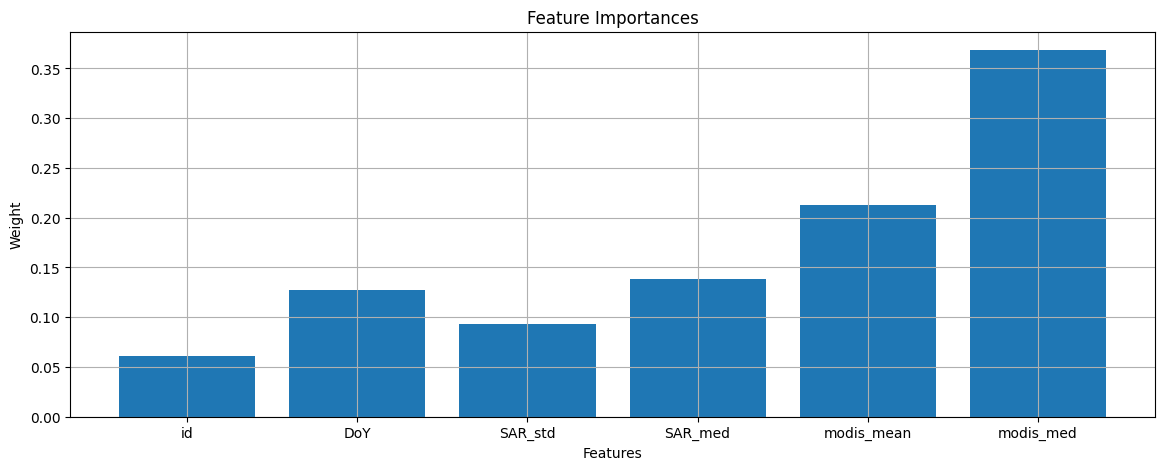

In [162]:
FeaImpPlot(X_train.columns,model.feature_importances_)

In [311]:
# Tunning Parameters - Multi Hyper Parameter
param_grid= {'max_depth': [3,4,5,6,7],
             'eta': [0.001,0.01,0.1,0.3,0.6,0.9],
             'gamma': [0, 10, 30],
             'reg_lambda': [0.001,0.01,0.1,1,5,9],
             'n_estimators':[50, 100, 150, 200]}
cv = KFold(n_splits=5, shuffle= True, random_state = 1)
clf=GridSearchCV(xg.XGBRegressor(random_state=40),param_grid,cv=cv)
clf=clf.fit(X_train,y_train)

# clf.best_score_
#clf.best_estimator_
# Test loss
# y_pred_opt=clf.predict(X_test)
# # score=r2_score(y_test, y_pred_opt)
# # print(score)

KeyboardInterrupt: 

### Data Modeling - SVR

In [158]:
model = SVR(C=6.6, epsilon=0.2)
model.fit(X_train,y_train)
cv = KFold(n_splits=5, shuffle= True, random_state = 1)
scoring = 'neg_root_mean_squared_error'
Val_score=  cross_val_score(estimator=model, X=X_train, y=y_train,cv=cv,scoring = scoring)
score = Val_score.mean()
print(f'Val Loss: {-score:.2f}')
test_df = test_validation(model,X_test,y_test)
#test_df

Val Loss: 0.16
Test RMSE score: 0.14
Test MAE score: 0.11
The N.o samples larger than 0.1: 19
The Unacceptable Ratio: 0.50


In [317]:
#model.dual_coef_# ((1,16)

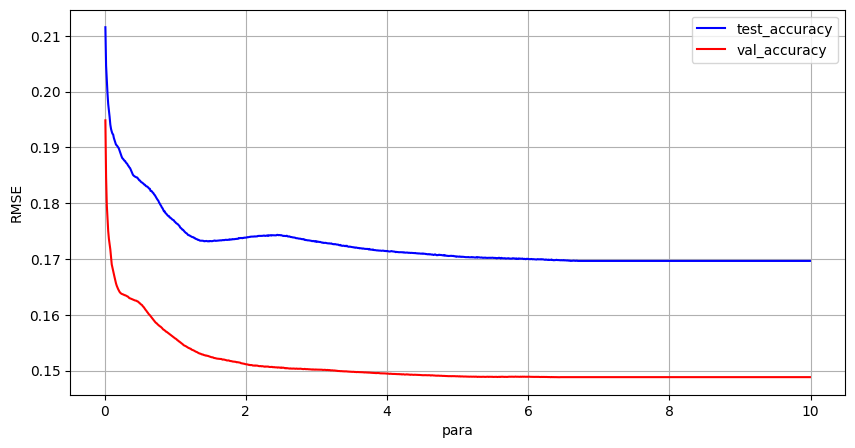

The optimal parameter [6.6]


In [314]:
#### Tuning part
C_max=10 # let learning_rate as a default value - unchange much
C_list=np.arange(0.01,C_max,0.01)
Test_Acc = []
Val_Acc = []
cv = KFold(n_splits=5, shuffle= True, random_state = 1)
scoring_RMSE = 'neg_root_mean_squared_error'
scoring_R2 = 'r2'
for C in C_list:
    model = SVR(C=C, epsilon=0.2)
    model.fit(X_train,y_train)
    
    Val_score=  cross_val_score(estimator=model, X=X_train, y=y_train,cv=cv,scoring = scoring_RMSE)
    y_pred_test = model.predict(X_test)
    # Accuracy    
    Test_Acc.append(mean_squared_error(y_test, y_pred_test,squared=False))
    Val_Acc.append(-Val_score.mean())

HyperTuningPlot(C_list,Test_Acc,Val_Acc)

### Satcking Example 

In [ ]:
estimators =[
                ('SVR', SVR(C=6.6, epsilon=0.2)),
                ('RFR', RandomForestRegressor(n_estimators=140, max_depth=6,random_state=0)),                
            ]
final_estimator = xg.XGBRegressor(n_estimators=150, max_depth=3, eta=0.01,gamma=0)
reg = StackingRegressor(estimators=estimators, final_estimator=final_estimator)
reg.fit(X_train,y_train)
cv = KFold(n_splits=5, shuffle= True, random_state = 1)
scoring = 'neg_root_mean_squared_error'
Val_score=  cross_val_score(estimator=reg, X=X_train, y=y_train,cv=cv,scoring = scoring)
score = Val_score.mean()
print(f'Val Loss: {-score:.2f}')
test_df,acc = test_validation(reg,X_test,y_test)
# test_df

## Data Modeling - RFR

In [215]:
model = RandomForestRegressor(n_estimators=86, max_depth=26,random_state=0)
scoring = 'neg_root_mean_squared_error'
model = TrainingModel(model,X_train,y_train,scoring)[0]
test_df,acc = test_validation(model,X_test,y_test)
#test_df

Val Loss: 0.14
Test RMSE score: 0.13
Test MAE score: 0.10
The N.o samples larger than 0.1: 14
The Unacceptable Ratio: 0.37


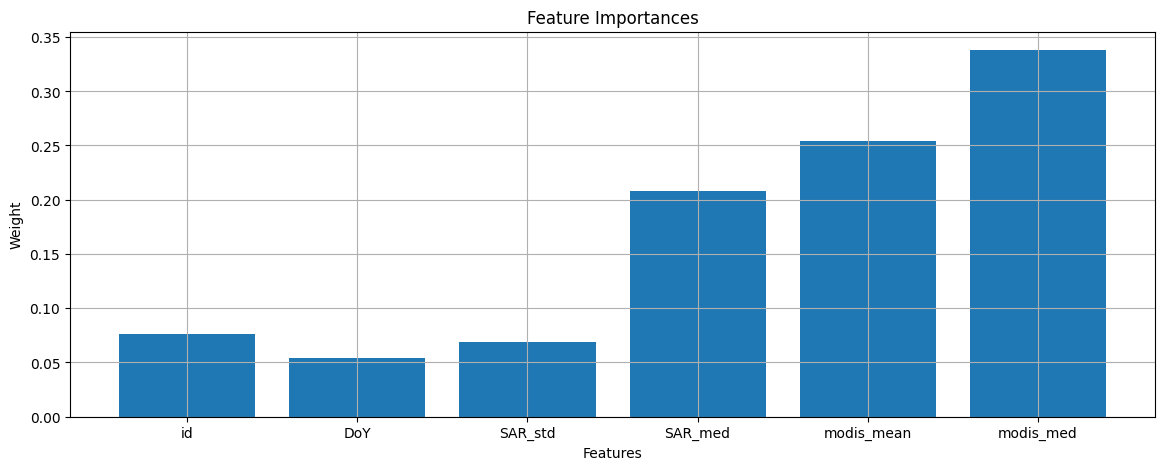

In [192]:
# Model Evaluation
FeaImpPlot(X_train.columns,model.feature_importances_)

In [216]:
## Save Model
title = f'RFR_8field_Tuned_{acc:.2f}_6_Features_wOrdinal.sav'
# SaveModel(model,savePath,title)

In [133]:
#FeatureSelection(model,X_train,y_train,min_features_to_select=5)

Index(['id', 'year_id', 'DoY', 'SAR_mean', 'SAR_std', 'SAR_med', 'modis_mean',
       'modis_std', 'modis_med'],
      dtype='object')
[ True False  True  True  True  True  True False  True]


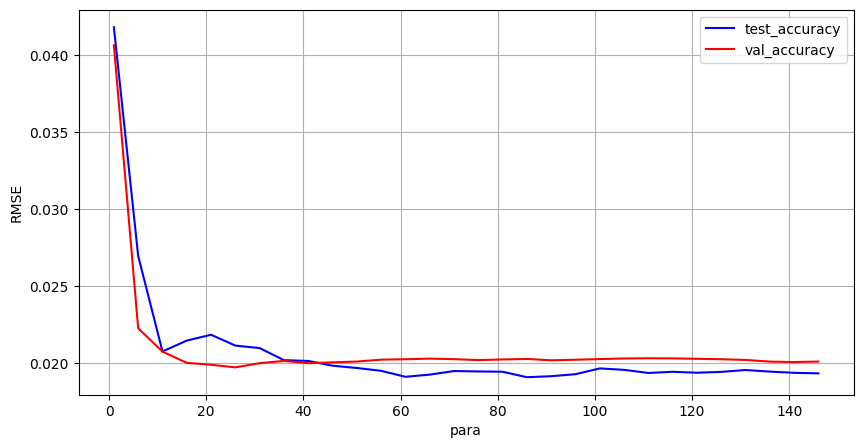

The optimal parameter [86]


In [198]:
C_max= 150 # let learning_rate as a default value - unchange much
C_min = 1
C_list=np.arange(C_min,C_max,5)
Test_Acc = []
Val_Acc = []
cv = KFold(n_splits=5, shuffle= True, random_state = 1)
scoring_MSE = 'neg_mean_squared_error'
scoring_R2 = 'r2'
for C in C_list:
    model = RandomForestRegressor(n_estimators=C, max_depth=6,random_state=0)
    model.fit(X_train,y_train)    
    
    Val_score=  cross_val_score(estimator=model, X=X_train, y=y_train,cv=cv,scoring = scoring_MSE)
    y_pred_test = model.predict(X_test)
    # Accuracy    
    Test_Acc.append(mean_squared_error(y_test, y_pred_test))
    Val_Acc.append(-Val_score.mean())

HyperTuningPlot(C_list,Test_Acc,Val_Acc)

## Gaussian Processes

In [12]:
import gpytorch
from gpytorch.models import ExactGP
import torch

In [13]:
from tqdm import tqdm
# We are using exact GP inference with a zero mean and RBF kernel
class ExactGPModel(ExactGP):
    '''
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ExactGPModel(train_x, train_y, likelihood)
    '''
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        # Initialize the zero smeans
        self.mean_module = gpytorch.means.ZeroMean()
        # Using the Radial Basis Fuction (RBF) kernal
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        # Return the multvaireateNormal Distribution # Joint Normal Distribution
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def Training_process(training_iter,model,train_x,train_y,optimizer,mll):
    model.train()
    loop = tqdm(range(training_iter))    
    for i in loop:
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        if i % 30 == 0:
            print(f'Iter {i+1:d}/{training_iter:d} - Loss: {loss.item():.3f} '
                  f'squared lengthscale: '
                  f'{model.covar_module.base_kernel.lengthscale.item():.3f} '
                  f'noise variance: {model.likelihood.noise.item():.3f}')
        optimizer.step()    

def SaveModelGP(model,title):    
    if not os.path.exists(f'{savePath}/model/'):
        os.makedirs( f'{savePath}/model/')     
    torch.save(model,title)
    
def LoadModelGP(title):
    model = torch.load(title)
    model.eval()
    return model

In [17]:
years = ['2019','2020','2021']
X_train, X_test, y_train, y_test = DataSplitting(preprocessed_dataset,sfd_ids,years,TestRatio = 0.1,random_state=0)

In [18]:
# First let's convert our data into tensors for use with PyTorch
train_x = torch.tensor(np.array(X_train))
train_y = torch.tensor(np.array(y_train))
test_y = torch.tensor(np.array(y_test))

# Initialize Gaussian likelihood
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)
training_iter = 1000

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer, includes GaussianLikelihood parameters
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Set our loss as the negative log GP marginal likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [19]:
Training_process(training_iter,model,train_x,train_y,optimizer,mll)

  2%|█▎                                                                              | 16/1000 [00:00<00:12, 77.48it/s]

Iter 1/1000 - Loss: 0.818 squared lengthscale: 0.693 noise variance: 0.693


  5%|████▏                                                                          | 53/1000 [00:00<00:08, 109.52it/s]

Iter 31/1000 - Loss: 0.699 squared lengthscale: 0.848 noise variance: 0.554


  8%|██████▏                                                                        | 78/1000 [00:00<00:08, 113.28it/s]

Iter 61/1000 - Loss: 0.579 squared lengthscale: 0.993 noise variance: 0.434


 11%|████████▉                                                                     | 114/1000 [00:01<00:07, 111.58it/s]

Iter 91/1000 - Loss: 0.456 squared lengthscale: 1.118 noise variance: 0.335


 14%|██████████▉                                                                   | 140/1000 [00:01<00:07, 116.83it/s]

Iter 121/1000 - Loss: 0.333 squared lengthscale: 1.221 noise variance: 0.255


 17%|████████████▉                                                                 | 166/1000 [00:01<00:07, 115.49it/s]

Iter 151/1000 - Loss: 0.212 squared lengthscale: 1.299 noise variance: 0.192


 19%|██████████████▉                                                               | 191/1000 [00:01<00:07, 108.69it/s]

Iter 181/1000 - Loss: 0.095 squared lengthscale: 1.347 noise variance: 0.145


 23%|█████████████████▊                                                            | 229/1000 [00:02<00:06, 111.89it/s]

Iter 211/1000 - Loss: -0.014 squared lengthscale: 1.359 noise variance: 0.109


 25%|███████████████████▋                                                          | 253/1000 [00:02<00:06, 111.73it/s]

Iter 241/1000 - Loss: -0.113 squared lengthscale: 1.338 noise variance: 0.083


 29%|██████████████████████▉                                                       | 294/1000 [00:02<00:05, 119.76it/s]

Iter 271/1000 - Loss: -0.199 squared lengthscale: 1.297 noise variance: 0.064


 32%|████████████████████████▉                                                     | 319/1000 [00:02<00:05, 117.17it/s]

Iter 301/1000 - Loss: -0.270 squared lengthscale: 1.248 noise variance: 0.051


 34%|██████████████████████████▊                                                   | 344/1000 [00:03<00:05, 114.94it/s]

Iter 331/1000 - Loss: -0.326 squared lengthscale: 1.197 noise variance: 0.041


 38%|█████████████████████████████▊                                                | 382/1000 [00:03<00:05, 115.55it/s]

Iter 361/1000 - Loss: -0.366 squared lengthscale: 1.135 noise variance: 0.034


 41%|███████████████████████████████▊                                              | 408/1000 [00:03<00:05, 117.17it/s]

Iter 391/1000 - Loss: -0.394 squared lengthscale: 1.065 noise variance: 0.029


 43%|█████████████████████████████████▊                                            | 433/1000 [00:03<00:04, 117.12it/s]

Iter 421/1000 - Loss: -0.413 squared lengthscale: 0.996 noise variance: 0.025


 47%|████████████████████████████████████▊                                         | 472/1000 [00:04<00:04, 118.85it/s]

Iter 451/1000 - Loss: -0.424 squared lengthscale: 0.940 noise variance: 0.023


 50%|██████████████████████████████████████▋                                       | 496/1000 [00:04<00:04, 101.97it/s]

Iter 481/1000 - Loss: -0.430 squared lengthscale: 0.893 noise variance: 0.021


 53%|█████████████████████████████████████████▎                                    | 530/1000 [00:04<00:04, 103.08it/s]

Iter 511/1000 - Loss: -0.433 squared lengthscale: 0.854 noise variance: 0.020


 55%|███████████████████████████████████████████▏                                  | 554/1000 [00:05<00:04, 108.79it/s]

Iter 541/1000 - Loss: -0.435 squared lengthscale: 0.821 noise variance: 0.019


 59%|██████████████████████████████████████████████▎                                | 587/1000 [00:05<00:04, 96.39it/s]

Iter 571/1000 - Loss: -0.436 squared lengthscale: 0.795 noise variance: 0.018


 63%|████████████████████████████████████████████████▉                             | 627/1000 [00:05<00:03, 114.49it/s]

Iter 601/1000 - Loss: -0.437 squared lengthscale: 0.775 noise variance: 0.018


 65%|██████████████████████████████████████████████████▉                           | 653/1000 [00:05<00:02, 116.13it/s]

Iter 631/1000 - Loss: -0.437 squared lengthscale: 0.760 noise variance: 0.018


 68%|████████████████████████████████████████████████████▊                         | 677/1000 [00:06<00:02, 114.44it/s]

Iter 661/1000 - Loss: -0.437 squared lengthscale: 0.750 noise variance: 0.017


 71%|███████████████████████████████████████████████████████▍                      | 711/1000 [00:06<00:02, 103.15it/s]

Iter 691/1000 - Loss: -0.437 squared lengthscale: 0.743 noise variance: 0.017


 73%|█████████████████████████████████████████████████████████▎                    | 734/1000 [00:06<00:02, 103.61it/s]

Iter 721/1000 - Loss: -0.437 squared lengthscale: 0.738 noise variance: 0.017


 76%|████████████████████████████████████████████████████████████▍                  | 765/1000 [00:07<00:02, 88.84it/s]

Iter 751/1000 - Loss: -0.437 squared lengthscale: 0.735 noise variance: 0.017


 81%|██████████████████████████████████████████████████████████████▊               | 806/1000 [00:07<00:01, 118.29it/s]

Iter 781/1000 - Loss: -0.437 squared lengthscale: 0.733 noise variance: 0.017


 84%|█████████████████████████████████████████████████████████████████▎            | 837/1000 [00:07<00:01, 128.01it/s]

Iter 811/1000 - Loss: -0.437 squared lengthscale: 0.732 noise variance: 0.017


 86%|███████████████████████████████████████████████████████████████████▎          | 863/1000 [00:07<00:01, 120.07it/s]

Iter 841/1000 - Loss: -0.437 squared lengthscale: 0.732 noise variance: 0.017


 89%|█████████████████████████████████████████████████████████████████████▎        | 888/1000 [00:08<00:00, 113.82it/s]

Iter 871/1000 - Loss: -0.437 squared lengthscale: 0.731 noise variance: 0.017


 92%|███████████████████████████████████████████████████████████████████████▌      | 917/1000 [00:08<00:00, 124.21it/s]

Iter 901/1000 - Loss: -0.437 squared lengthscale: 0.731 noise variance: 0.017


 94%|█████████████████████████████████████████████████████████████████████████▌    | 943/1000 [00:08<00:00, 117.58it/s]

Iter 931/1000 - Loss: -0.437 squared lengthscale: 0.731 noise variance: 0.017


 98%|████████████████████████████████████████████████████████████████████████████▋ | 983/1000 [00:08<00:00, 122.70it/s]

Iter 961/1000 - Loss: -0.437 squared lengthscale: 0.731 noise variance: 0.017


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 110.80it/s]

Iter 991/1000 - Loss: -0.437 squared lengthscale: 0.730 noise variance: 0.017


In [24]:
test_df, acc = test_validation(model,X_test,y_test,GP=True)
#test_df

Test RMSE score: 0.14
Test MAE score: 0.11
The N.o samples larger than 0.1: 17
The Unacceptable Ratio: 0.45


In [25]:
# save model
title = f'{savePath}/model/GP_model_{acc:.2f}_wOrdianl.pt'
# SaveModelGP(model,title)
# load model
# model = LoadModelGP(title)

## Prediction

In [160]:
savePath

'ImageResults/SAR_Rescontruction/'

C:\Users\qle\AppData\Local\Temp\ipykernel_21652\3351529481.py:236: PerformanceWarning: indexing past lexsort depth may impact performance.
  Date = df_dataset.loc[sfd_id_choice,'Date']
C:\Users\qle\AppData\Local\Temp\ipykernel_21652\3351529481.py:237: PerformanceWarning: indexing past lexsort depth may impact performance.
  NDVI = df_dataset.loc[sfd_id_choice,'NDVI_mean']


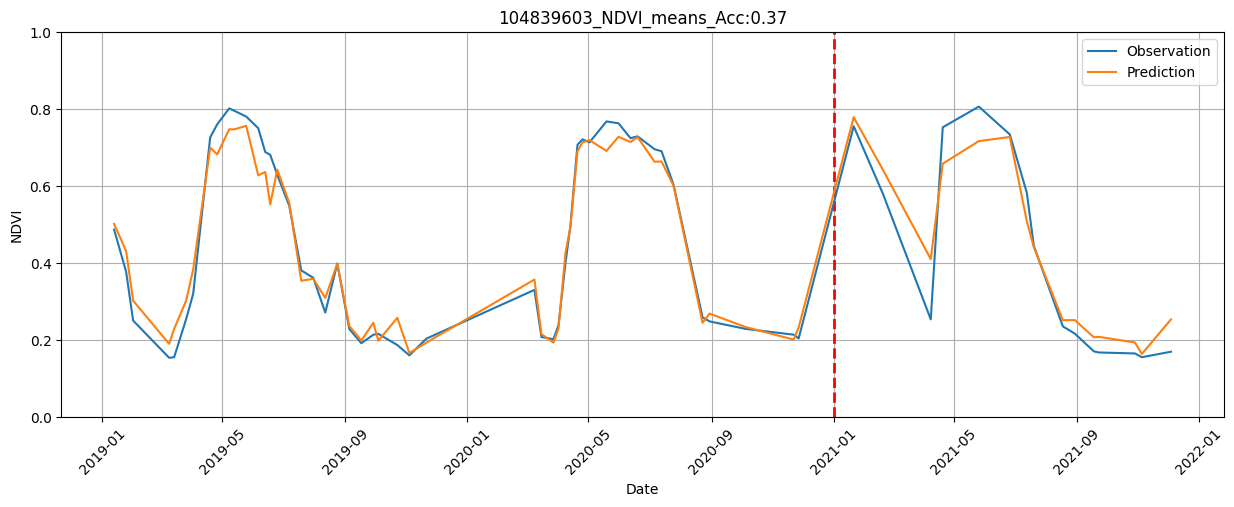

In [205]:
years = ['2019','2020','2021']
# sfd_id_choice = 104839603
# title = 'RFR_8field_Tuned_0.18_6_Features_YearID.sav'
# model = loadModel(savePath,title)
all_smooth_feature_df = Pred_Obs_plot(preprocessed_dataset,sfd_id_choice,model,selected[3:-1],acc,years=None,GB=False,save=False)

C:\Users\qle\AppData\Local\Temp\ipykernel_21652\3351529481.py:236: PerformanceWarning: indexing past lexsort depth may impact performance.
  Date = df_dataset.loc[sfd_id_choice,'Date']
C:\Users\qle\AppData\Local\Temp\ipykernel_21652\3351529481.py:237: PerformanceWarning: indexing past lexsort depth may impact performance.
  NDVI = df_dataset.loc[sfd_id_choice,'NDVI_mean']


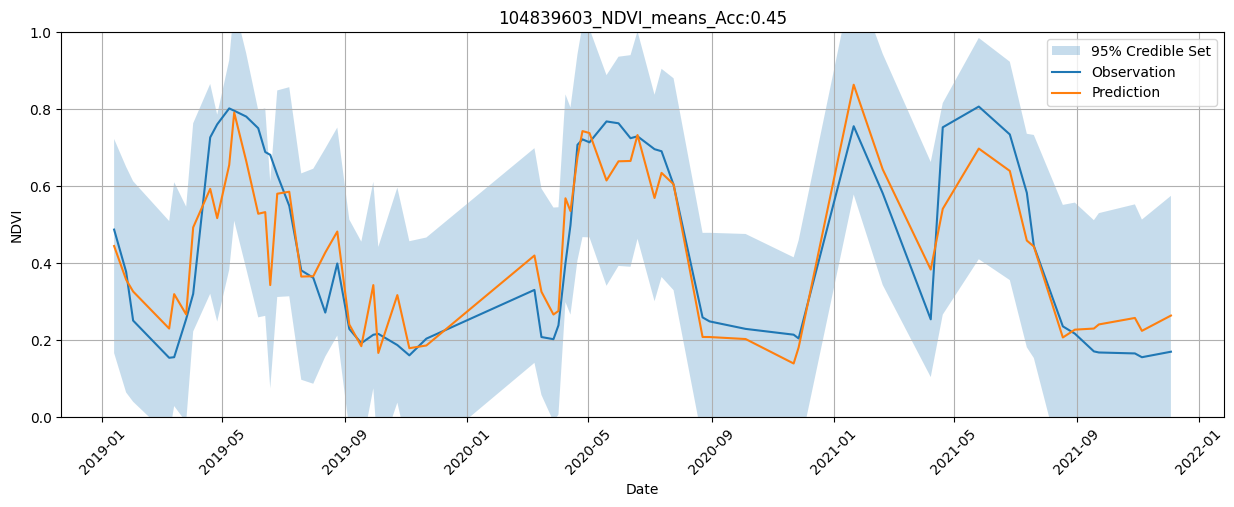

In [212]:
years = ['2019','2020','2021']
all_smooth_feature_df = Pred_Obs_plot(preprocessed_dataset,sfd_id_choice,model,selected[3:-1],acc,years=years,GB=True,Confident_drawing=True,save=False)

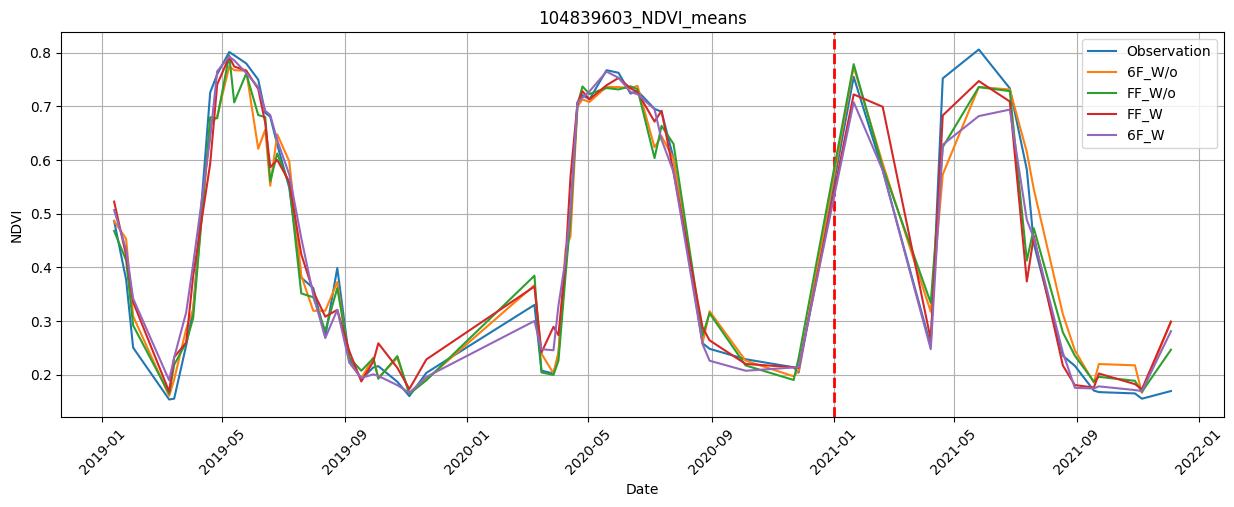

In [684]:
df_dataset = preprocessed_dataset.copy()
df_dataset = df_dataset.set_index(['field_id','year'])    
plt.figure(figsize =(15,5))
title = f'{sfd_id_choice}_NDVI_means'
plt.title(title)
d = datetime(2021,1,1)

    
plt.axvline(x=d, c='r', lw=2, linestyle='dashed')
plt.plot(Date,NDVI,label='Observation')
plt.plot(Date_pred,six_feature_df['pred'],label='6F_W/o')
plt.plot(Date_pred,all_feature_df['pred'],label='FF_W/o')
plt.plot(Date_pred,all_smooth_feature_df['pred'],label='FF_W')
plt.plot(Date_pred,six_smooth_feature_df['pred'],label='6F_W')
plt.grid()
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('NDVI')
plt.legend(loc = 'upper right')

# Difference Prediction

In [299]:
savePath = 'ImageResults/SAR_Rescontruction/'
features = ['id','SAR_mean','SAR_std','SAR_med','modis_mean','modis_std','modis_med']

In [300]:
# Example:
field_id = [104839603]
Date = '20190130'
SAR_mean = [0.52]
SAR_std = [0.03]
SAR_med = [0.89]
modis_mean = [0.6]
modis_std = [0.7]
modis_med = [0.9]
# NDVI_mean = ???
dict_pred = {
    'id': field_id,
    'Date': Date,
    'SAR_mean': SAR_mean,
    'SAR_std': SAR_std,
    'SAR_med': SAR_med,
    'modis_mean': modis_mean,
    'modis_std': modis_std,
    'modis_med': modis_med,
}
df_pred = pd.DataFrame(dict_pred)

In [301]:
# Preprocessing the predicted value
df_pred['Date'] = pd.to_datetime(df_pred['Date'],format='%Y%m%d')
df_pred.insert(1, "DoY", df_pred['Date'].apply(lambda x:x.dayofyear), True)
df_pred['id'] = np.where(sfd_ids==field_id)[0][0]

scaler_names = [savePath + feature + '_scaler.gz' for feature in features]
scalers = [joblib.load(scaler_name) for scaler_name in scaler_names ]

for feature,scaler in zip(features,scalers):
    df_pred[feature] = scaler.transform(df_pred[feature].values.reshape(-1,1))
df_pred.drop(['Date'],axis=1,inplace=True)

In [302]:
loaded_model = loadModel(savePath,'RFR_8field_Tuned_model.sav')
# Predict
result = loaded_model.predict(df_pred )
result

array([0.73300785])

In [ ]:
loaded_model

In [303]:
# Last model
cv = KFold(n_splits=5, shuffle= True, random_state = 1)
scoring = 'neg_root_mean_squared_error'
Val_score=  cross_val_score(estimator=loaded_model, X=X_train, y=y_train,cv=cv,scoring = scoring)
score = Val_score.mean()
print(f'Val Loss: {-score:.2f}')
test_df = test_validation(loaded_model,X_test,y_test)

Val Loss: 0.12
Test RMSE score: 0.13
Test MAE score: 0.09
The N.o samples larger than 0.1: 21
The Unacceptable Ratio: 0.30
